# Recommendation Analysis - AO3

This notebook will train 3 recommendation algorithms on the AO3 interaction data: TopPop, Random, and ALS. We generate accuracy metrics focused on the recommendations of each algorithm. We look at the prevalence of AO3 warnings in the users' histories vs their top recommendations for each algorithm. Data is collected from https://archiveofourown.org/ and the warnings are pulled from the Webis Trigger Warning Corpus 2023 https://doi.org/10.5281/zenodo.7976807.

In [1]:
# Install necessary packages. Uncomment following lines if the packages are not included in your environment.

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install implicit
# !pip install scikit-learn
# !pip install scipy

from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    plt.style.use("seaborn-v0_8-darkgrid")
except:
    plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'font.size': 16})

### Load Relevant Data Frames

In [2]:
# user_id | work_id | 1 (binary rating)
interaction_table = pd.read_csv("data/ao3_interaction_table.csv").drop(columns="Unnamed: 0")
interaction_table["rating"] = 1

# work_id | n_hits | n_kudos | n_users | one-hot encoded warnings
work_metadata = pd.read_csv("data/ao3_sensitivity_table.csv").drop(columns="Unnamed: 0")

### Select 1000 Random Users
These users will be used to generate recommendations for throughout the analysis

In [3]:
np.random.seed(42)
random_users = np.random.choice(interaction_table['user_id'].unique(), 1000, replace=False)

# Dictionary user_id : set(work_ids)
random_user_works_dict = {user : set(interaction_table[interaction_table["user_id"] == user]["work_id"].values) for user in random_users}

### Helper Functions

In [4]:
def metrics_at_k(recommendations, interactions_dict):
    """
    Calculates the Precision@k and Recall@k for the given recommendations
    Args:
        recommendations: dictionary of user_id : [recs]
        interactions: dictionary of used_id : [work_ids]. Ground truth interactions. user_ids are the same as in recommendations
    Returns:
        Precision@k = num recommended items @k that are relevant (i.e. were liked by user) / k
        Recall@k = num recommended items @ k that are relevant (i.e. were liked by user) / num relevant items
    
    """
    precisions = []
    recalls = []
    for user, works in interactions_dict.items():
        user_recs = recommendations[user]
        hits = works.intersection(user_recs)
        precisions.append(len(hits)/len(user_recs))
        recalls.append(len(hits)/len(works))
    
    return sum(precisions)/len(precisions), sum(recalls)/len(recalls)


def train_test_split_user(df, test_size=0.1):
    train_list = []
    test_list = []
    
    grouped = df.groupby('user_id')
    
    for user_id, group in grouped:
        train, test = train_test_split(group, test_size=test_size, random_state=36)
        train_list.append(train)
        test_list.append(test)
    
    # Concatenate all the train and test DataFrames
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    
    return train_df, test_df

## Model Training

Create 90-10 train-test split of user interactions to generate accuracy metrics. The split is made with respect to each user, so 90% of a users ratings appear in the trainset and 10% appear in the testset.

Due to computational constraints, we will generate the train-test split for metrics with a representative subset of the data including 10% of the works and their interactions.

In [167]:
# Given the size of the data, select a random 10% subset for model analysis
work_metadata_subset = work_metadata.sample(frac=0.1, random_state=31)

In [168]:
# Remove works with less than three likes (according to user list)
mask = work_metadata_subset.apply(lambda row: len(row['users']) >= 3, axis=1)
work_metadata_subset = work_metadata_subset[mask]
print(f"Number of works with at least 3 likes (first pass): {len(work_metadata_subset)}")
      
# Update user_table to include only works that are present after filtering users and works
works_to_keep = work_metadata_subset['work_id'].unique()
interaction_table_subset = interaction_table[interaction_table['work_id'].isin(works_to_keep)]

user_counts = interaction_table_subset['user_id'].value_counts()
users_to_keep = user_counts[user_counts >= 3].index
interaction_table_subset = interaction_table_subset[interaction_table_subset['user_id'].isin(users_to_keep)]
existing_users = set(interaction_table_subset["user_id"].unique())
print(f"Number of users with at least 3 interactions (first pass): {len(existing_users)}")

# Update work_metadata users list to remove filtered out users
work_metadata_subset['users'] = work_metadata_subset['users'].apply(lambda x: [user for user in x if user in existing_users])

Number of works with at least 3 likes (first pass): 30611
Number of users with at least 3 interactions (first pass): 405571


In [169]:
train_interactions, test_interactions = train_test_split_user(interaction_table_subset)

In [170]:
train_user_works_dict = train_interactions.groupby('user_id')['work_id'].apply(set).to_dict()
test_user_works_dict = test_interactions.groupby('user_id')['work_id'].apply(set).to_dict()

### Top Pop Algorithm

This algorithm recommends users the most popular works in the dataset. We consider popularity in terms of the number of interactions (publicly available user kudos/likes) a work has received.

In [5]:
def gen_top_pop_recs(top_pop_algo, k, interactions_dict, remove_seen):
    top_pop_recs = {}
    for user_id, seen_works in interactions_dict.items():
        if remove_seen:
            top_pop_recs[user_id] = []
            for i in range(len(top_pop_algo)):
                if top_pop_algo[i] not in seen_works:
                    top_pop_recs[user_id].append(top_pop_algo[i])
                if len(top_pop_recs[user_id]) == k:
                    break
        else:
            top_pop_recs[user_id] = top_pop_algo[:k]
    return top_pop_recs

Generate Precision, Recall, and F1 scores on the subset test split.

In [6]:
# Rank all works by average rating
work_ratings_count = interaction_table_subset.groupby('work_id').size().reset_index(name='ratings_count')
top_popular_works = work_ratings_count.sort_values(by='ratings_count', ascending=False)['work_id']
top_pop_algo = top_popular_works.tolist()

In [28]:
for k in [10, 50, 100]:
    # Recommend works not seen in the trainset
    test_top_pop_recs = gen_top_pop_recs(top_pop_algo, k, train_user_works_dict, False)
    # Evaluate on the testset
    precision, recall = metrics_at_k(test_top_pop_recs, test_user_works_dict)
    f1 = 2*recall*precision / (recall + precision)
    print(f"Precision@k={k}: {precision}")
    print(f"Recall@k={k}: {recall}")
    print(f"F1@k={k}: {f1}\n")

Precision@k=10: 0.001143572888594192
Recall@k=10: 0.005337594484445195
F1@k=10: 0.0018835891719484912

Precision@k=50: 0.0007102578833299833
Recall@k=50: 0.016141798411271235
F1@k=50: 0.0013606457719230038

Precision@k=100: 0.000570257735390238
Recall@k=100: 0.026654517330629925
F1@k=100: 0.001116625915477719



Train the algorithm on the entire dataset and generate recommendations for the 1000 users that do not appear in their history.

In [ ]:
work_ratings_count = interaction_table.groupby('work_id').size().reset_index(name='ratings_count')
top_popular_works = work_ratings_count.sort_values(by='ratings_count', ascending=False)['work_id']
top_pop_algo = top_popular_works.tolist()

In [7]:
# All users will get recommended the top 100 ranked works they haven't seen for analysis
top_pop_recs = gen_top_pop_recs(top_pop_algo, 100, random_user_works_dict, True)

### Random Algorithm

The Random recommendation algorithm chooses works from the interaction table at random following a uniform distribution.

In [8]:
def gen_random_recs(k, interactions, interactions_dict, remove_seen):
    random_recs = {}
    candidate_works = set(interactions["work_id"].unique())
    if remove_seen:
        for user_id, seen_works in interactions_dict.items():
            works_for_rec = list(candidate_works.difference(seen_works))
            random_recs[user_id] = set(np.random.choice(works_for_rec, size=k, replace=False))
    else:
        for user_id in interactions_dict.keys():
            random_recs[user_id] = set(np.random.choice(candidate_works, size=k, replace=False))
    return random_recs

Generate Precision, Recall, and F1 scores on the subset test split. Recommendations will include items the user has already seen in order to evaluate these metrics.

In [33]:
for k in [10, 50, 100]:
    # Recommend works not seen in the trainset
    test_random_recs = gen_random_recs(k, interaction_table, train_user_works_dict, True)
    # Evaluate on works in the testset
    precision, recall = metrics_at_k(test_random_recs, test_user_works_dict)
    if recall + precision > 0:
        f1 = 2*recall*precision / (recall + precision)
    else:
        f1 = 0
    print(f"Precision@k={k}: {precision}")
    print(f"Recall@k={k}: {recall}")
    print(f"F1@k={k}: {f1}\n")

Precision@k=10: 4.635439910644498e-05
Recall@k=10: 0.00031739291432388646
F1@k=10: 8.089438619012662e-05

Precision@k=50: 4.960906968200305e-05
Recall@k=50: 0.0017091127217344361
F1@k=50: 9.641944794308302e-05

Precision@k=100: 4.864746246649855e-05
Recall@k=100: 0.0032925079208681284
F1@k=100: 9.587830383465869e-05



Recommend 100 unseen works from the entire dataset to the 1000 random users for analysis

In [9]:
random_recs = gen_random_recs(100, interaction_table, random_user_works_dict, True)

## Implicit Alternating Least Squares (ALS)

Implicit Alternating Least Squares is an algorithm developed for recommendation in settings where only implicit user feedback is available (e.g. in the absence of ratings). The method is introduced in "Collaborative Filtering for Implicit Feedback Datasets" by Hu et al. We use the Implicit python library's implementation (https://benfred.github.io/implicit/index.html) and adapt code from the tutorial provided in https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-clickstream-data-dffc86c8c65.

In [171]:
def get_als_recs(sparse_user_work, user_vecs, work_vecs, k, interactions, interactions_dict, remove_seen):
    als_recs = {}
    for user_id in interactions_dict.keys():
        user_code = interactions[interactions["user_id"] == user_id].iloc[0]["user_code"]
        user_interactions = sparse_user_work[user_code,:].toarray()
        # Items with no interactions become 1
        user_interactions = user_interactions.reshape(-1) + 1
        
        if remove_seen:
            # To only recommend items not in the interactions table, make items the user has already interacted with 0
            user_interactions[user_interactions > 1] = 0
            
        rec_vector = user_vecs[user_code, :].dot(work_vecs.T).toarray()
        min_max = MinMaxScaler()
        rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1, 1))[:, 0]
        recommend_vector = user_interactions * rec_vector_scaled
        
        work_idxs = np.argsort(recommend_vector)[::-1][:k]
        als_recs[user_id] = []
        for idx in work_idxs:
            als_recs[user_id].append(interaction_table.iloc[idx]["work_id"])
    return als_recs

Train ALS on the subset train set and evaluate on the subset test set for precision, recall, and f1 metrics.

In [172]:
# Convert ids into categorical codes. Will be used later in ALS
train_interactions['user_code'] = train_interactions['user_id'].astype("category").cat.codes
train_interactions['work_code'] = train_interactions['work_id'].astype("category").cat.codes

sparse_work_user = sparse.csr_matrix((train_interactions['rating'].astype(float), (train_interactions['work_code'], train_interactions['user_code'])))
sparse_user_work = sparse.csr_matrix((train_interactions['rating'].astype(float), (train_interactions['user_code'], train_interactions['work_code'])))

model = AlternatingLeastSquares(factors=50, regularization=0.5, iterations=50)

alpha = 15
data = (sparse_work_user * alpha).astype('double')
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Use item an work factor matrices to generate recommendations
user_vecs = sparse.csr_matrix(model.item_factors)
work_vecs = sparse.csr_matrix(model.user_factors)

# Recommend k top ranked works to all users. remove_seen is True to so recommendations are unseen to the trainset and then evaluated against the testset.
for k in [100]:
    als_recs_test = get_als_recs(sparse_user_work, user_vecs, work_vecs, k, train_interactions, train_user_works_dict, True)
    precision, recall = metrics_at_k(als_recs_test, test_user_works_dict)
    if recall + precision > 0:
        f1 = 2*recall*precision / (recall + precision)
    else:
        f1 = 0
    print(f"Precision@k={k}: {precision}")
    print(f"Recall@k={k}: {recall}")
    print(f"F1@k={k}: {f1}\n")

Train on the entire dataset and recommend 100 unseen items to the 1000 randomly selected users for analysis.

In [14]:
interaction_table['user_code'] = interaction_table['user_id'].astype("category").cat.codes
interaction_table['work_code'] = interaction_table['work_id'].astype("category").cat.codes

sparse_work_user = sparse.csr_matrix((interaction_table['rating'].astype(float), (interaction_table['work_code'], interaction_table['user_code'])))
sparse_user_work = sparse.csr_matrix((interaction_table['rating'].astype(float), (interaction_table['user_code'], interaction_table['work_code'])))

model = AlternatingLeastSquares(factors=50, regularization=0.5, iterations=50)

alpha = 15
data = (sparse_work_user * alpha).astype('double')
model.fit(data)

# Use item an work factor matrices to generate recommendations
user_vecs = sparse.csr_matrix(model.item_factors)
work_vecs = sparse.csr_matrix(model.user_factors)

# Recommend 100 unseen works for analysis
als_recs = get_als_recs(sparse_user_work, user_vecs, work_vecs, 100, interaction_table, random_user_works_dict, True)

  0%|          | 0/50 [00:00<?, ?it/s]

## Warning Analysis

In this section we generate various graphs to visualize the amplification of warnings in the 1000 random users' recommendations.

In [15]:
warnings = set(work_metadata.columns[-36:])
warnings

{'ableism',
 'abortion',
 'abuse',
 'abusive-language',
 'addiction',
 'animal-abuse',
 'blood-gore',
 'body-shaming',
 'child-abuse',
 'childbirth',
 'classism',
 'collective-violence',
 'death',
 'dysmorphia',
 'homophobia',
 'incest',
 'kidnapping',
 'mental-illness',
 'miscarriage',
 'other-abuse',
 'other-aggression',
 'other-discrimination',
 'other-medical',
 'other-mental-health',
 'other-pregnancy',
 'other-sexual',
 'pornography',
 'procedures',
 'racism',
 'religious-discrimination',
 'self-harm',
 'sexism',
 'sexual-abuse',
 'suicide',
 'transphobia',
 'violence'}

In [139]:
def amplification_dfs(top_recommendations):
    warning_data_maps = {"warning": [], "data": []}
    for warning in warnings:
        warning_data_maps["warning"].append(warning)
        data = {'user_id': [], 'amplification_scores': [], 'history_warnings': [], 'recs_warnings': []}
        
        for user_id, work_ids in random_user_works_dict.items():
            # Count the fraction of works in user's history with warning
            user_history_warning_fraction = sum(work_metadata[work_metadata['work_id'].isin(work_ids)][warning])/(len(work_ids))

            # Count the fraction of works in user's top recommendations with warning
            try:
                user_recs_warning_fraction = sum(work_metadata[work_metadata['work_id'].isin(set(top_recommendations[user_id].astype(int)))][warning]) / len(top_recommendations[user_id].astype(int))
            except:
                user_recs_warning_fraction = sum(work_metadata[work_metadata['work_id'].isin(set(top_recommendations[user_id]))][warning]) / len(top_recommendations[user_id])
            
            # Calculate the ratio and append the data to the dictionary. Subtract 1 to normalize: amplification score = 0 means same fraction in both recs and history
            if user_history_warning_fraction == 0:
                data["amplification_scores"].append(user_recs_warning_fraction/(1/len(top_recommendations[user_id])) - 1)
            else:
                data["amplification_scores"].append(user_recs_warning_fraction/user_history_warning_fraction - 1)
            data["user_id"].append(user_id)
            data["history_warnings"].append(user_history_warning_fraction)
            data["recs_warnings"].append(user_recs_warning_fraction)
        warning_data_maps["data"].append(data)
    return pd.DataFrame(warning_data_maps)


def single_warning_amplification(warning, warning_data_maps, name="", color="purple", xlim=4):
    data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])
    av_amp = data["amplification_scores"].mean()
    print(f"{name} av amp for {warning}: {av_amp}")
    fig, ax = plt.subplots(figsize=(6,6))
    ax.axvline(x = 0, ymin = 0, ymax = 1, color="black", linestyle="dashed")
    ax.set_yscale('symlog')
    ax.set_xscale('symlog')
    ax.text(0.7, 0.75, f"Av score: \n{av_amp:2f}", transform = ax.transAxes, fontsize=16)
    sns.histplot(data=data["amplification_scores"], kde=True, bins=50, line_kws={'lw':5}, color=color, label=f'{name}', alpha=0.3)
    plt.title(f'AO3: {name} {warning} \nAmplification Scores', fontsize=18)
    plt.xlabel(f'Amplification of {warning}', fontsize=14)
    plt.ylabel('')
    plt.legend(loc='best', frameon=True)
    fig = plt.gcf()
    plt.show()
    plt.close()
                                          

def warning_distribution_plots(warning_data_maps):
    for warning in warnings:
        data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])

        fig, ax = plt.subplots()
        sns.histplot(data=data["history_warnings"], bins=20, kde=True, color='blue', label='User History', alpha=0.5)
        sns.histplot(data=data["recs_warnings"], bins=20, color='red', label='Top Recommendations', alpha=0.5)
        plt.title(f'{warning} in History vs Recommendations')
        plt.xlabel(f'Percent of Works with {warning}')
        plt.ylabel('Frequency')
        plt.legend()
        fig = plt.gcf()
        plt.show()
        plt.close()


def warning_amplification_plots(warning_data_maps):
    for warning in warnings:
        single_warning_amplification(warning, warning_data_maps)
        

def user_amplification_plots(warning_data_maps):
    summed_amplifications = np.zeros(len(random_user_works_dict))
    for warning in warnings:
        data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])
        summed_amplifications += np.array(data["amplification_scores"])
        
    fig, ax = plt.subplots()
    sns.histplot(data=summed_amplifications/len(warnings), bins=20, kde=True, color='green', label='Average Amplification', alpha=0.5)
    plt.xlabel(f'Average Amplification')
    plt.ylabel('Frequency')
    plt.legend()
    fig = plt.gcf()
    plt.show()
    plt.close()
    

def overlay_user_amplifications(dms):
    fig, ax = plt.subplots()
    for name, warning_data_maps, color in dms:
        summed_amplifications = np.zeros(len(random_user_works_dict))
        for warning in warnings:
            data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])
            summed_amplifications += np.array(data["amplification_scores"])
        print(f"{name} av amp: {summed_amplifications.sum()/(len(warnings)*len(random_user_works_dict))}")
        sns.histplot(data=summed_amplifications/len(warnings), kde=True, edgecolor=color, line_kws={'lw':3}, label=f'{name}', color=color, alpha=0.3)
    ax.axvline(x = 0, ymin = 0, ymax = 1, color="black", linestyle="dashed")
    plt.title('AO3: User Average Amplification Scores \nOver All Warnings', fontsize=22)
    plt.xlabel(f'Average Amplification', fontsize=18)
    plt.xlim(-1.5, 5)
    plt.xticks([0, 2, 4])
    plt.ylabel('')
    plt.legend(loc='best', fontsize=14)
    fig = plt.gcf()
    plt.show()
    plt.close()

def overlay_single_warning_amps(warning, dms):
    fig, ax = plt.subplots()
    for name, warning_data_maps, color in dms:
        data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])
        sns.histplot(data=data["amplification_scores"], bins=20, kde=True, color=color, label=f'{name}', alpha=0.5)
        av_amp = data["amplification_scores"].mean()
        print(f"{name} av amp for {warning}: {av_amp}")
    ax.axvline(x = 1, ymin = 0, ymax = 1, color="black", linestyle="dashed")
    ax.set_xlim(0, 6)
    plt.title(f'{warning} Amplification Scores')
    plt.xlabel(f'Amplification of {warning}')
    plt.ylabel('Frequency')
    plt.legend()
    fig = plt.gcf()
    plt.show()
    plt.close()

### Top Pop Algorithm

In [17]:
top_pop_amplification_dfs = amplification_dfs(top_pop_recs)

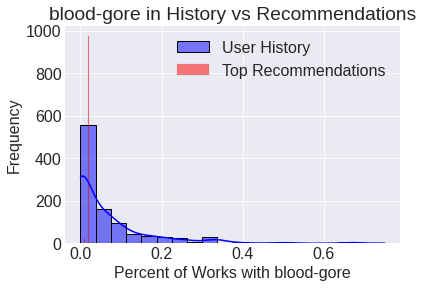

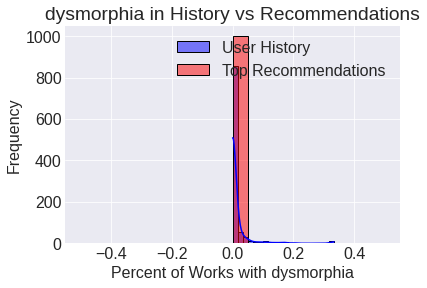

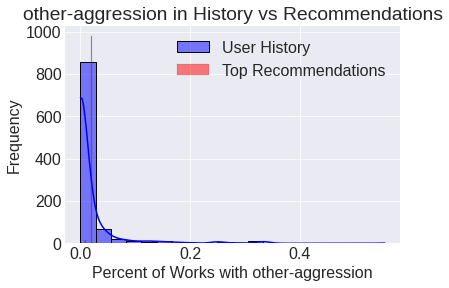

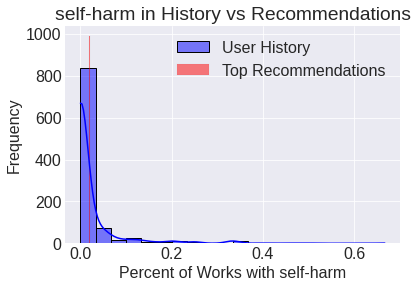

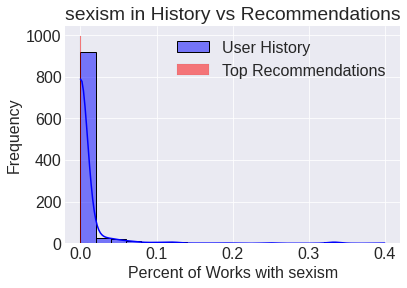

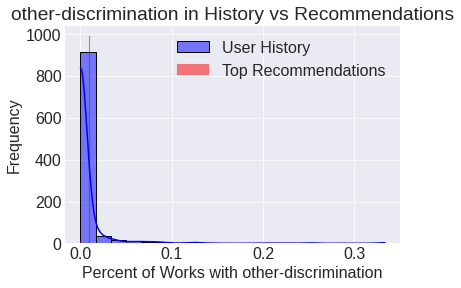

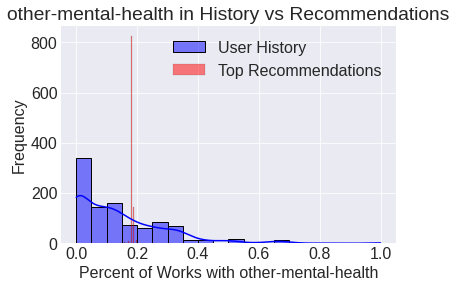

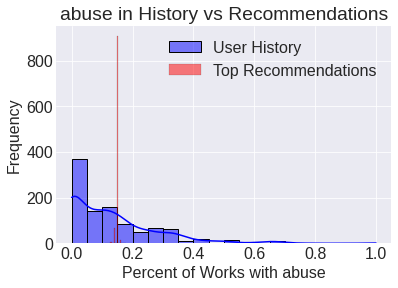

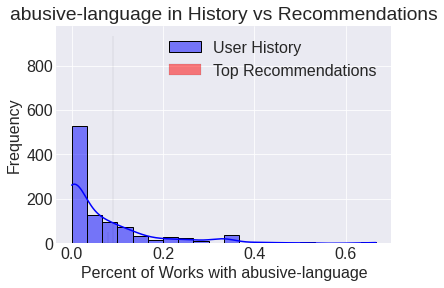

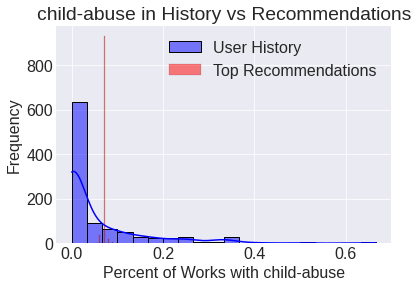

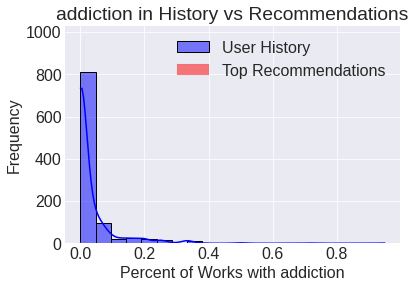

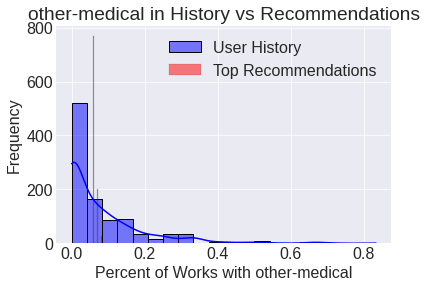

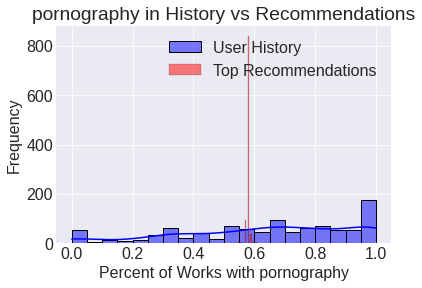

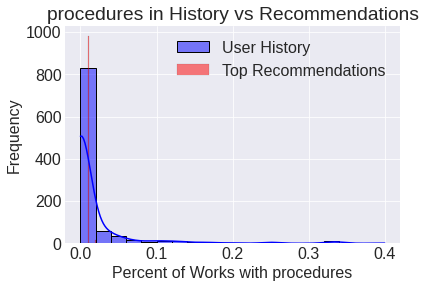

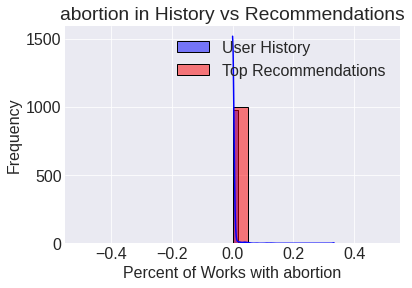

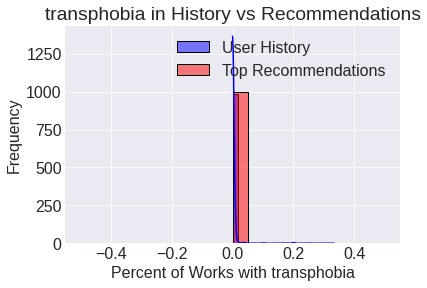

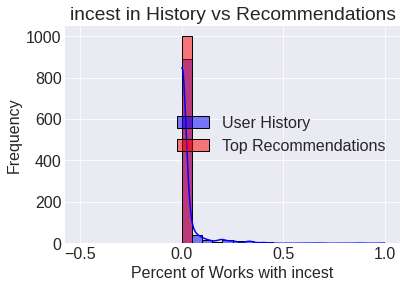

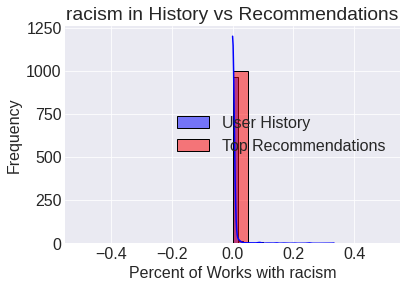

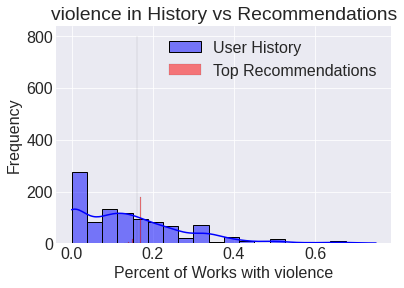

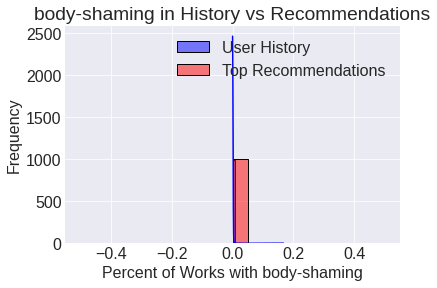

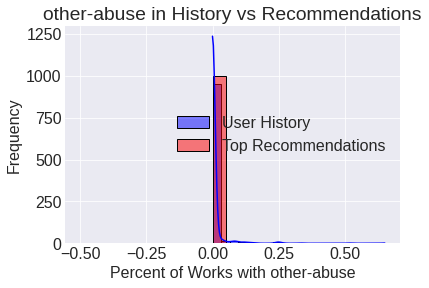

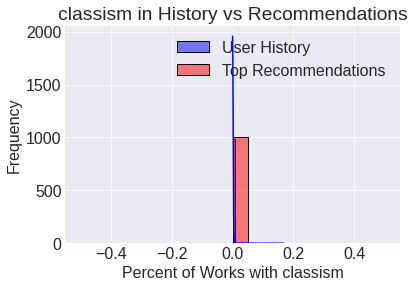

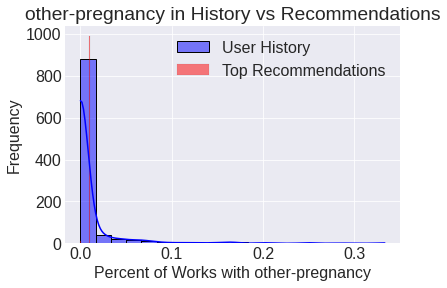

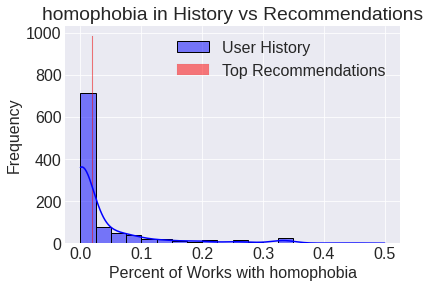

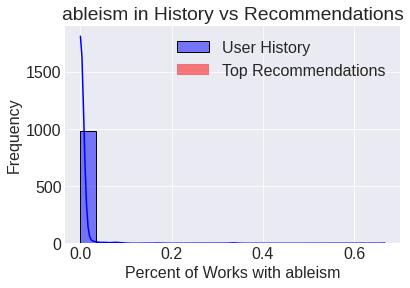

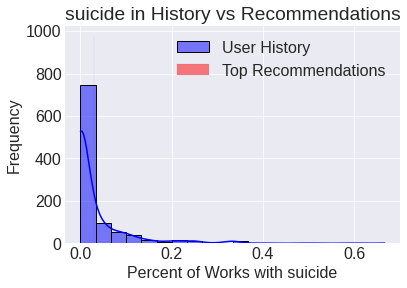

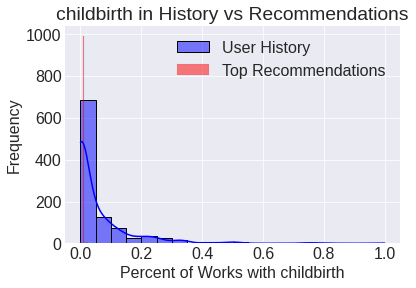

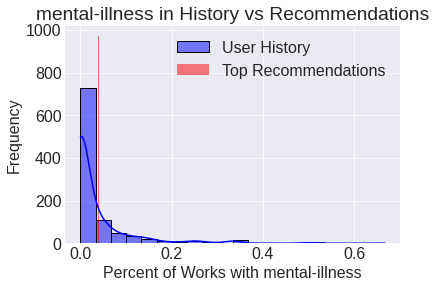

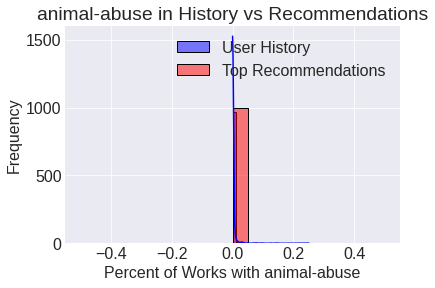

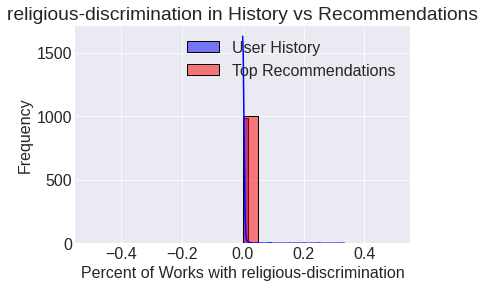

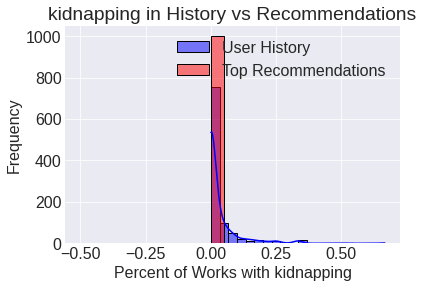

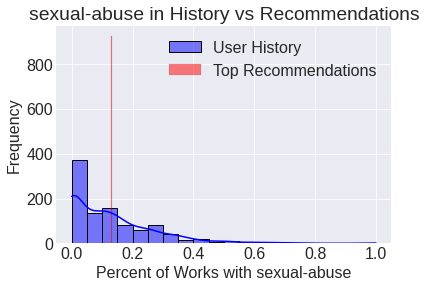

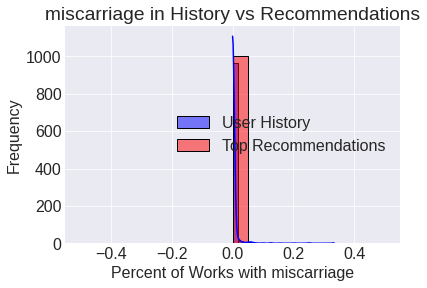

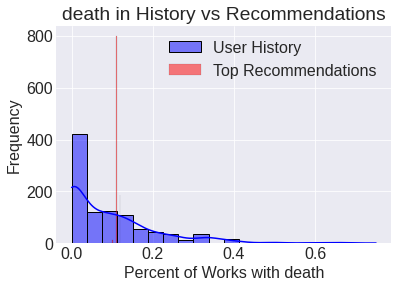

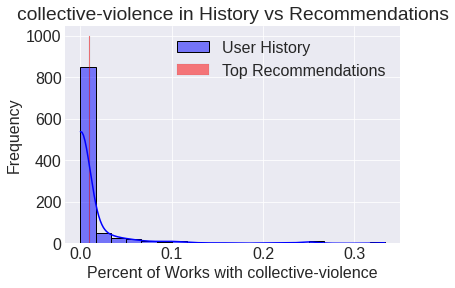

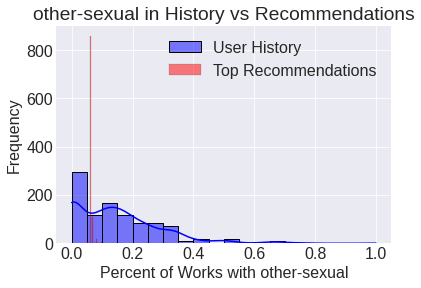

In [155]:
warning_distribution_plots(top_pop_amplification_dfs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for blood-gore: 0.1189764929500245


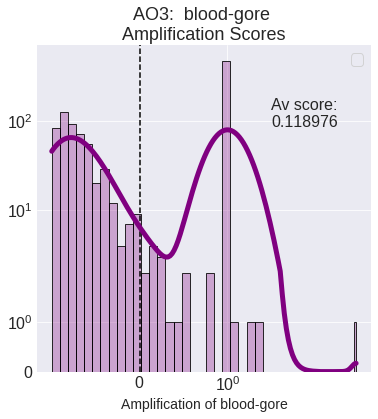

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for dysmorphia: -1.0


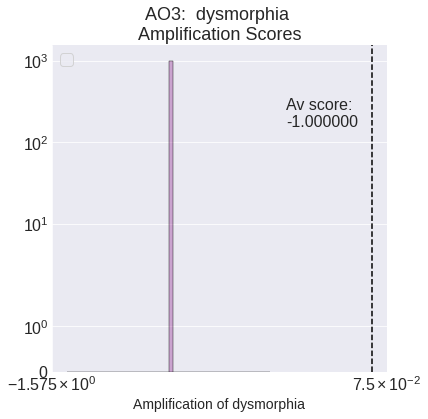

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-aggression: 0.7049084303941678


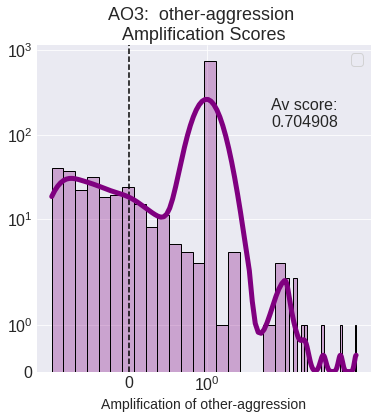

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for self-harm: 0.685430302752803


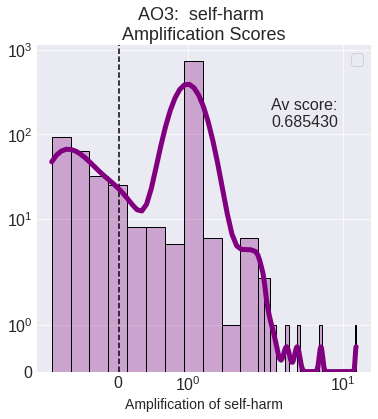

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for sexism: -0.9943237500000001


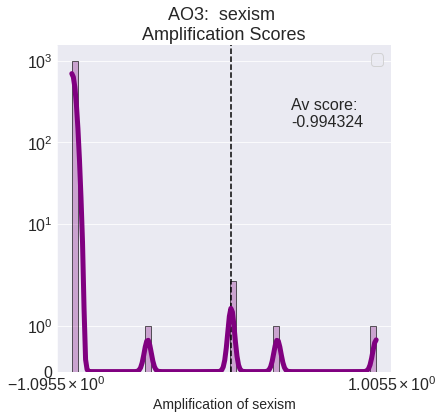

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-discrimination: -0.0507565303030303


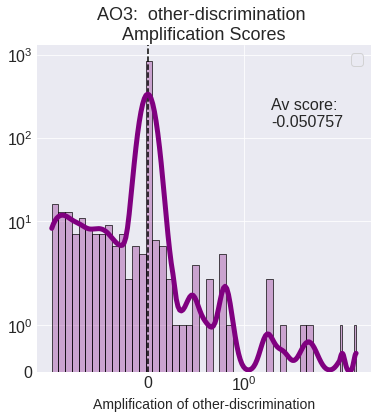

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-mental-health: 5.3785618715513275


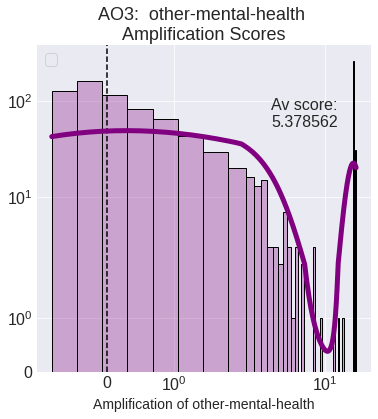

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abuse: 4.659344103297372


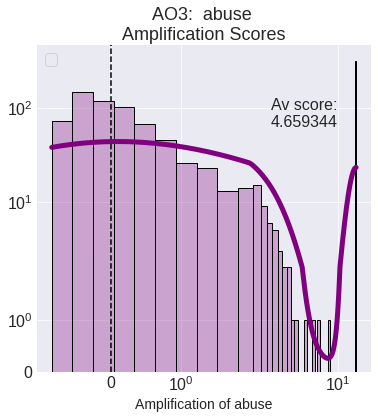

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abusive-language: 3.9375004020679274


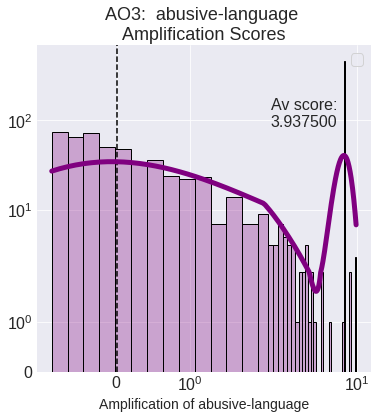

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for child-abuse: 3.5130680055926855


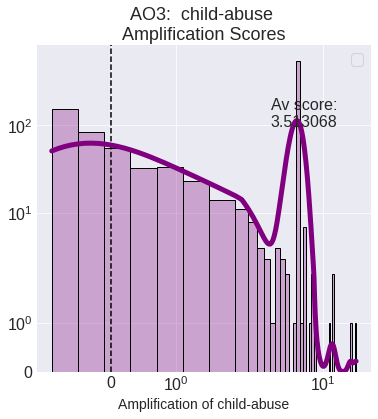

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for addiction: -0.23254928172821962


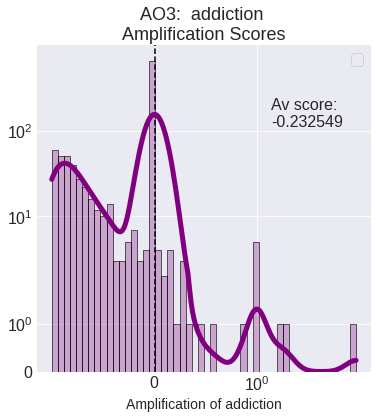

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-medical: 2.2155413524256105


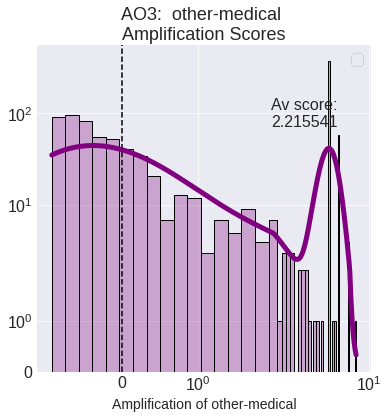

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for pornography: 3.0457541992582993


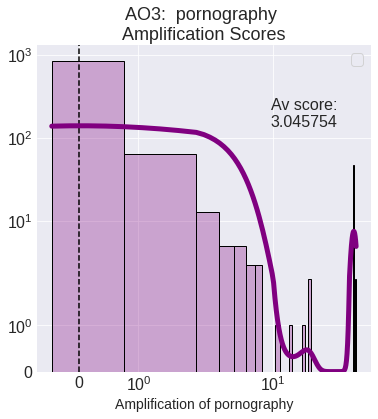

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for procedures: -0.12269852922077917


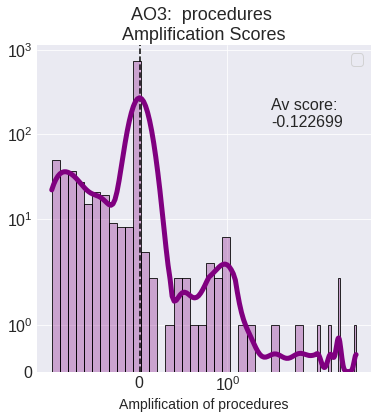

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abortion: -1.0


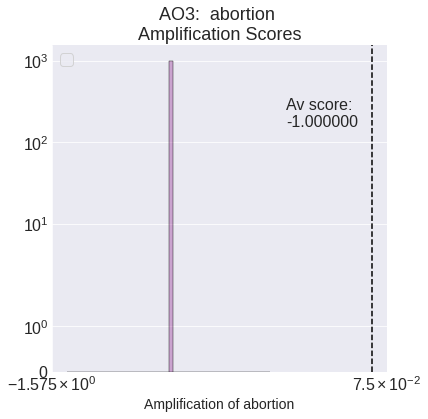

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for transphobia: -1.0


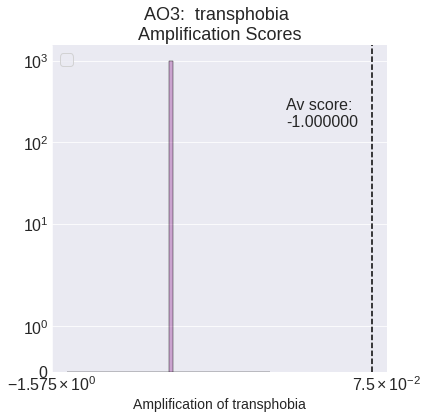

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for incest: -1.0


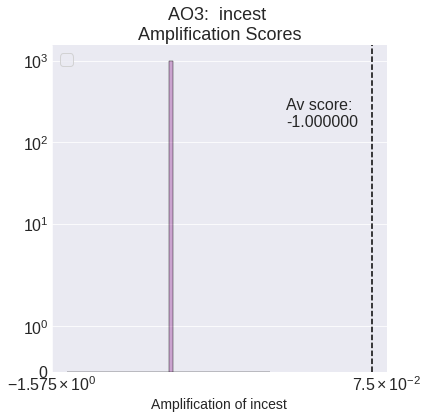

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for racism: -1.0


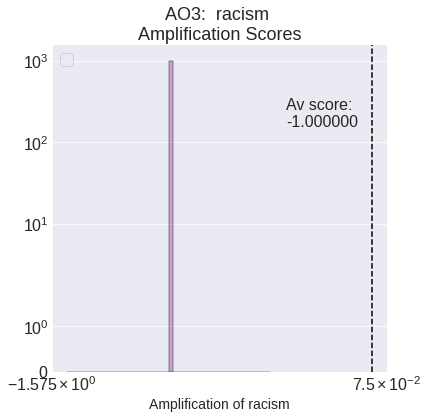

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for violence: 4.1913079070635275


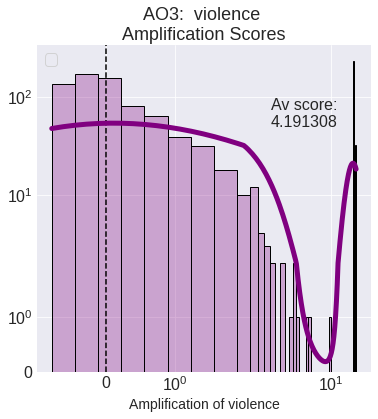

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for body-shaming: -1.0


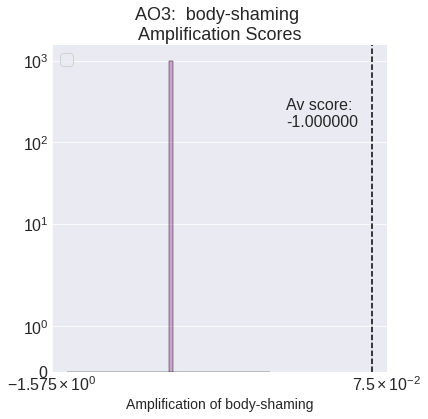

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-abuse: -1.0


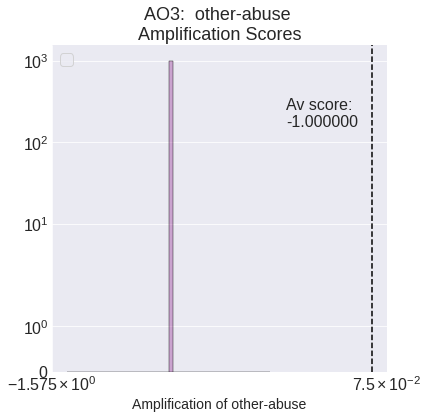

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for classism: -1.0


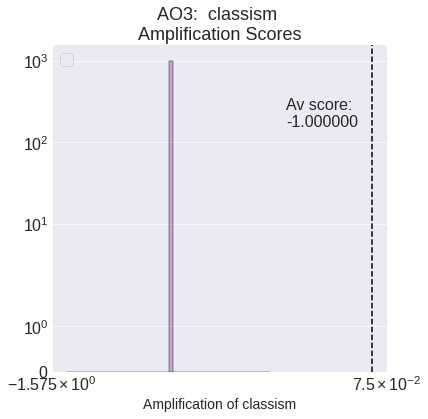

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-pregnancy: -0.08542192803030299


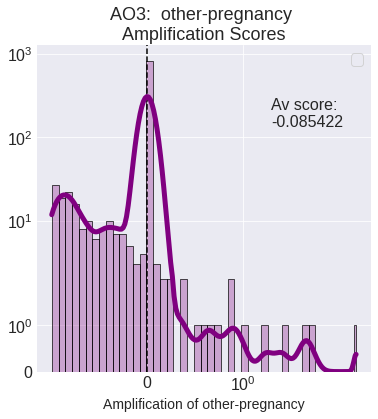

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for homophobia: 0.478369124042624


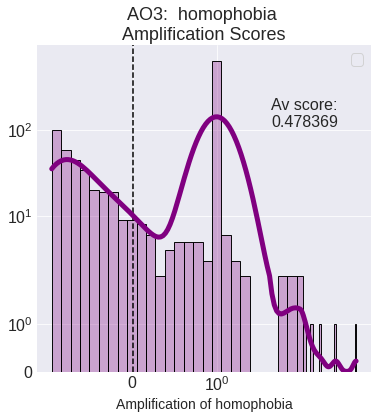

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for ableism: 0.011810833333333333


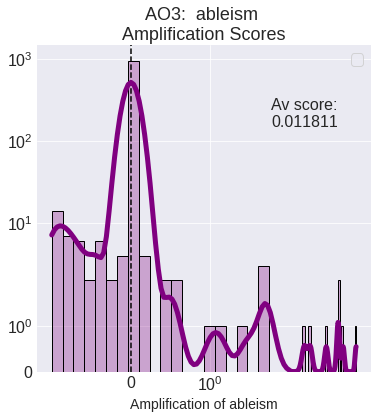

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for suicide: 1.189965549594063


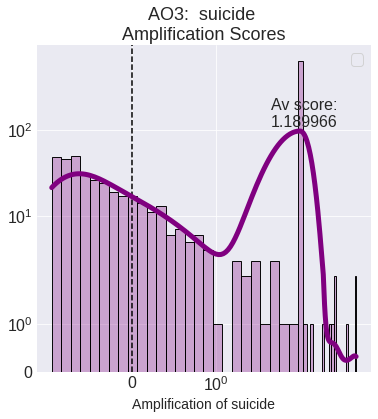

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for childbirth: -0.3587519254149113


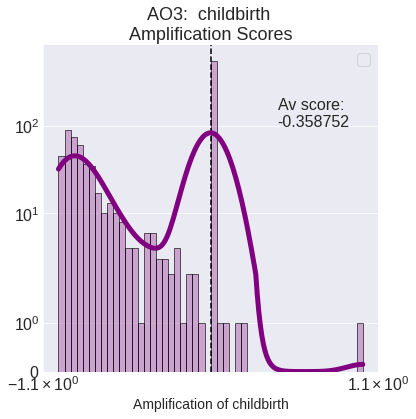

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for mental-illness: 1.8836355035711707


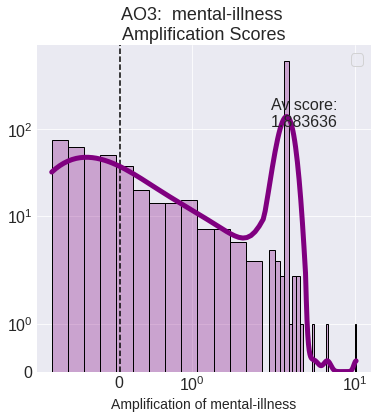

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for animal-abuse: -1.0


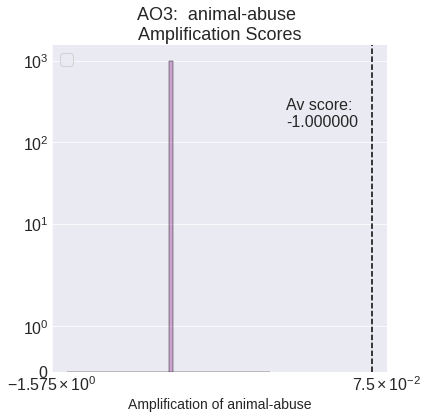

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for religious-discrimination: -1.0


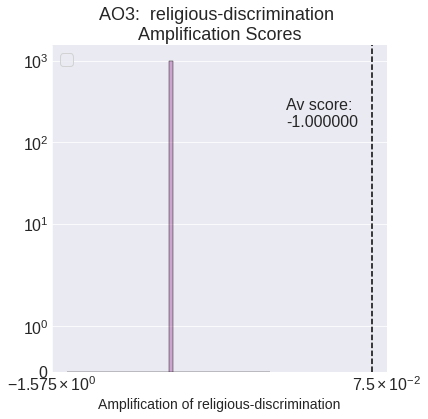

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for kidnapping: -1.0


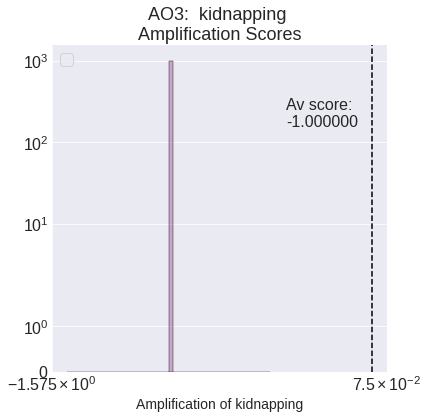

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for sexual-abuse: 4.000593685212684


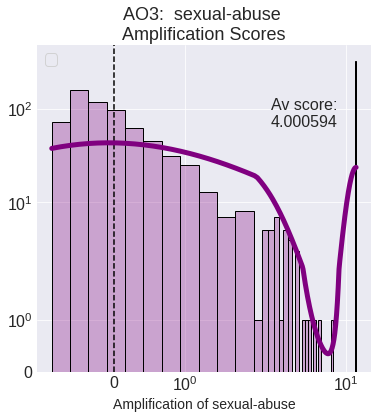

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for miscarriage: -1.0


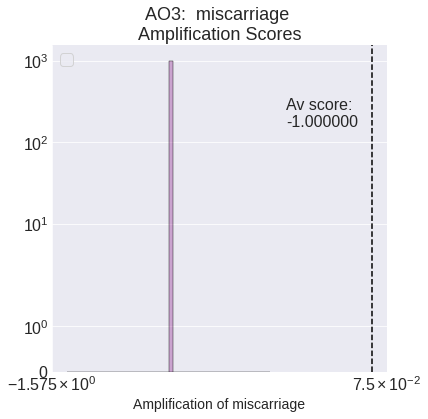

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for death: 4.0243023235575555


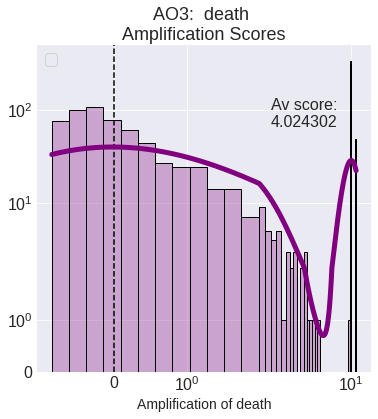

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for collective-violence: -0.10169576118326112


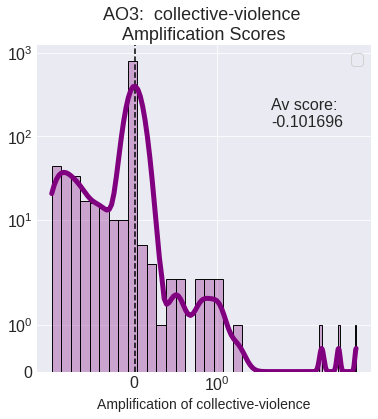

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-sexual: 0.9801047715219695


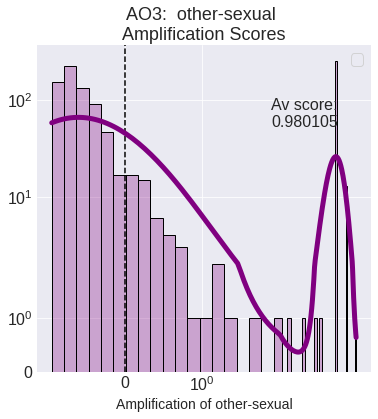

In [156]:
warning_amplification_plots(top_pop_amplification_dfs)

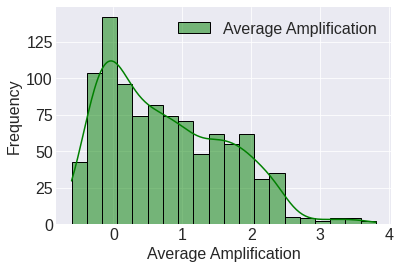

In [157]:
user_amplification_plots(top_pop_amplification_dfs)

### Random Algorithm

In [22]:
random_amplification_dfs = amplification_dfs(random_recs)

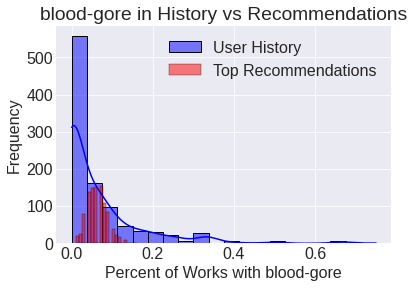

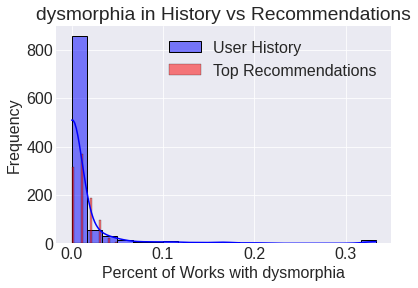

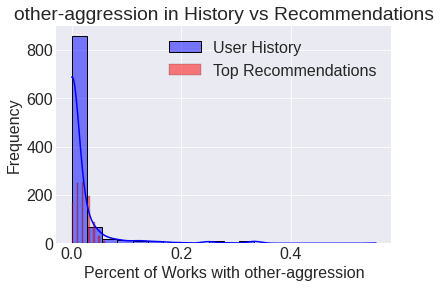

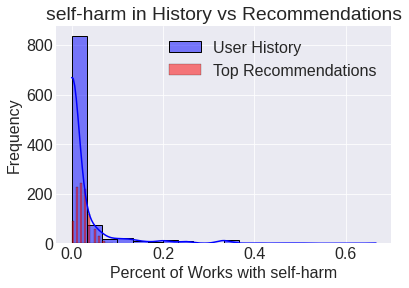

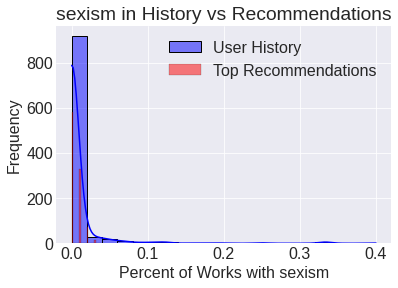

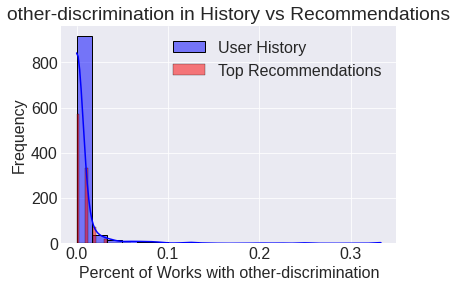

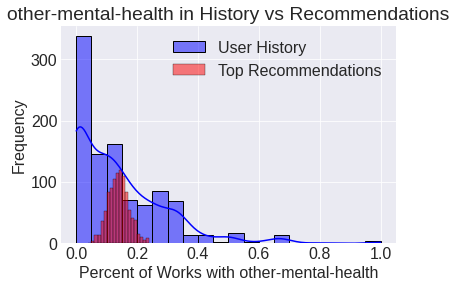

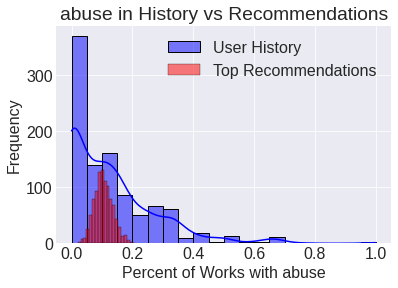

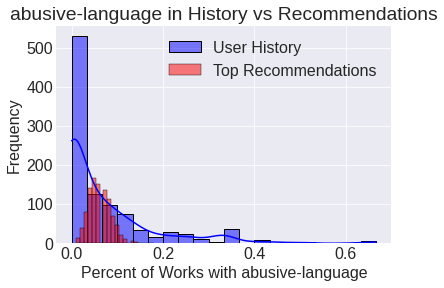

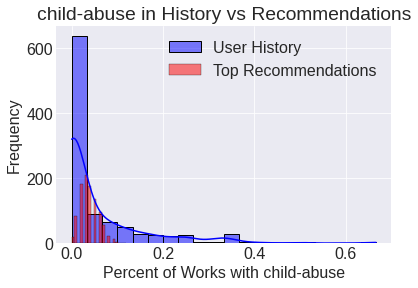

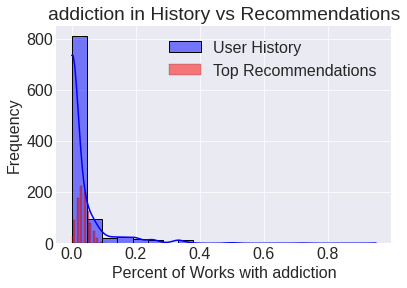

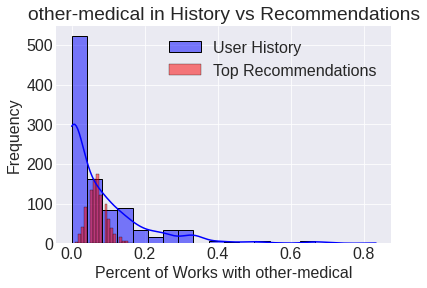

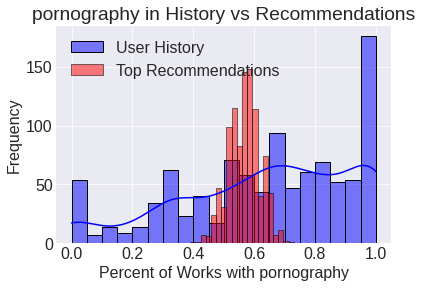

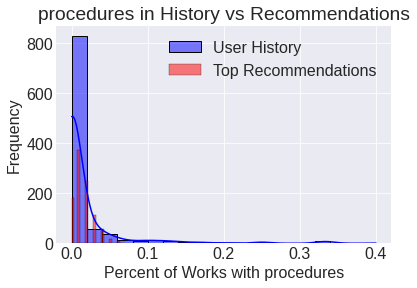

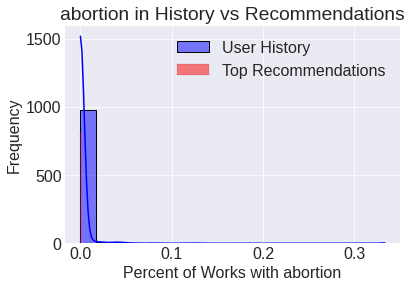

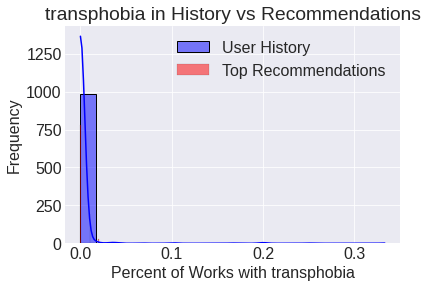

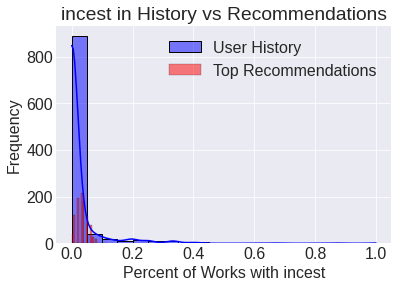

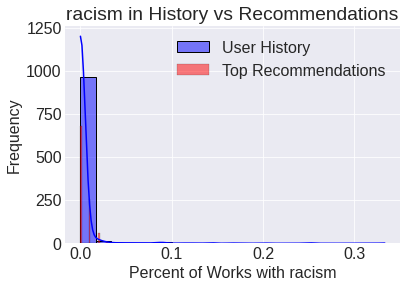

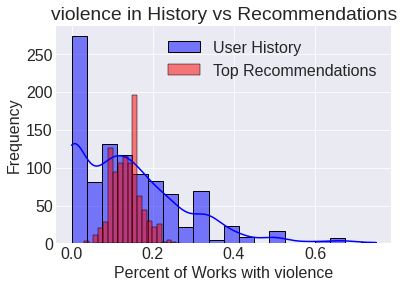

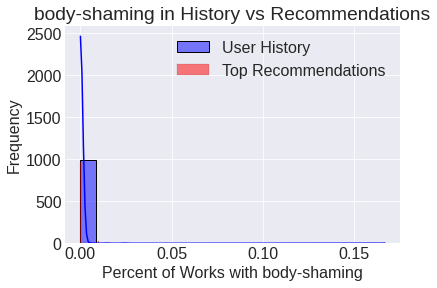

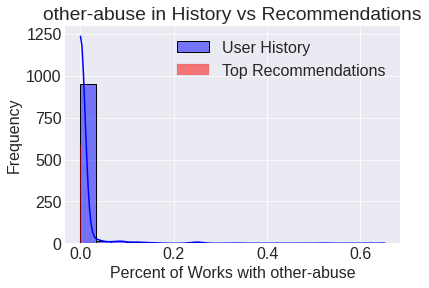

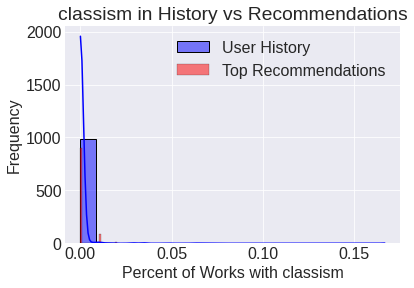

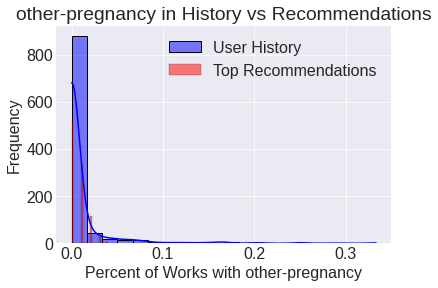

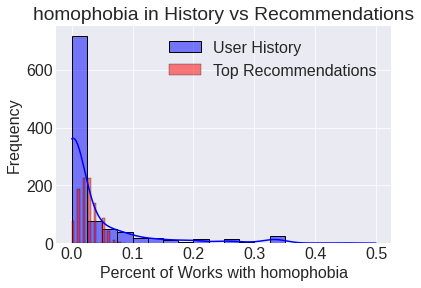

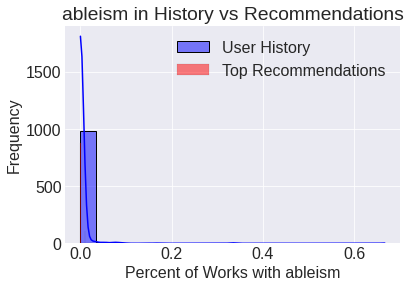

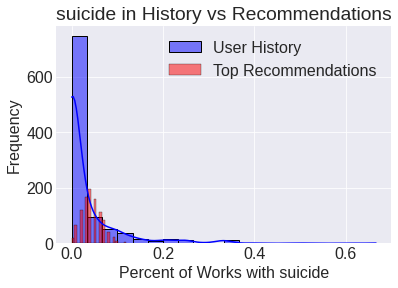

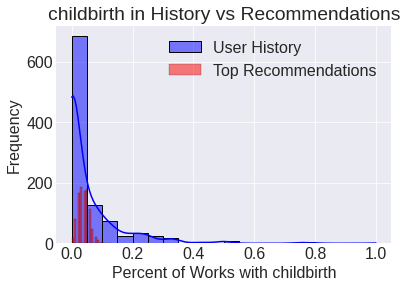

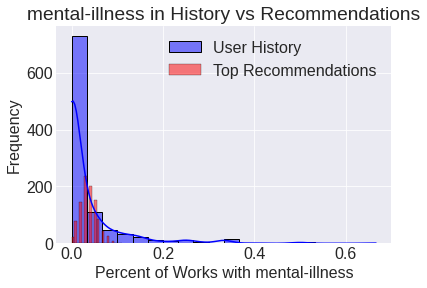

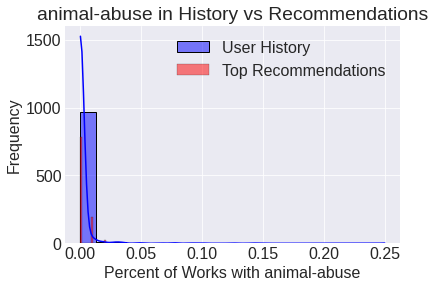

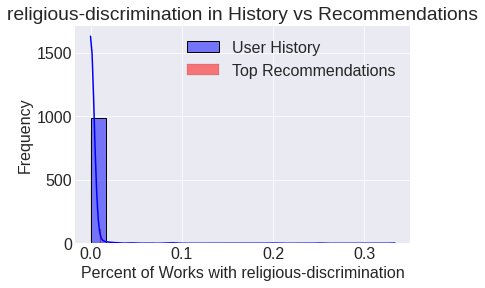

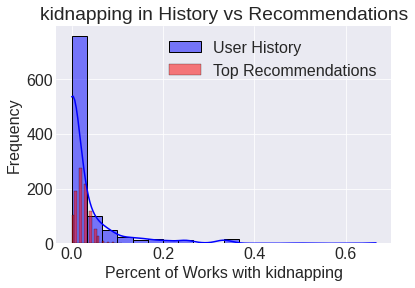

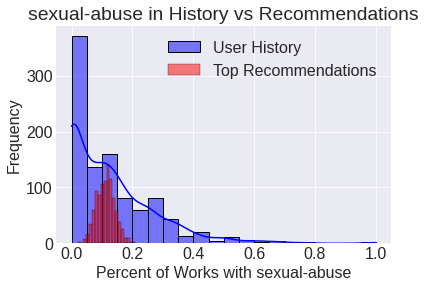

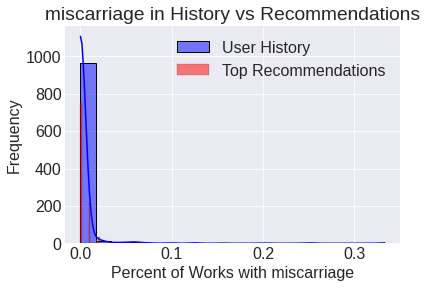

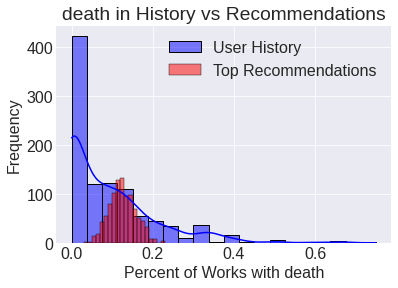

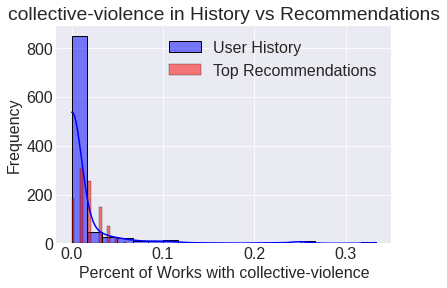

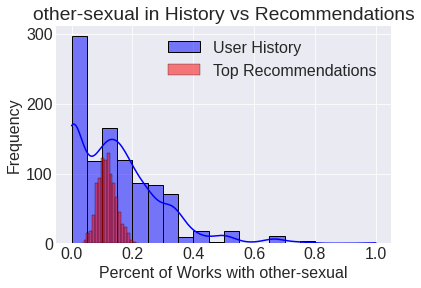

In [158]:
warning_distribution_plots(random_amplification_dfs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for blood-gore: 2.452120488397762


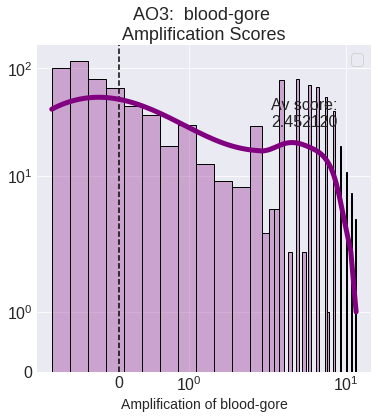

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for dysmorphia: 0.0733997619047619


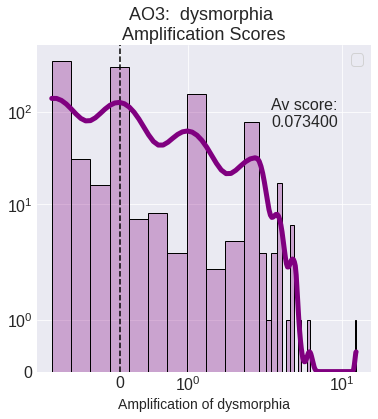

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-aggression: 0.6501542716450219


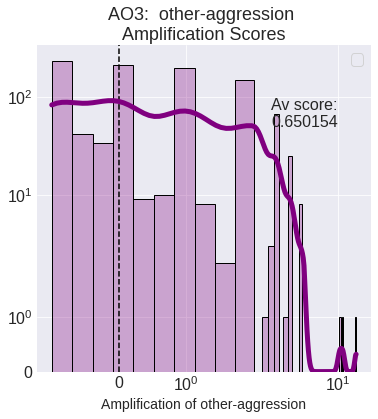

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for self-harm: 1.0054410356865353


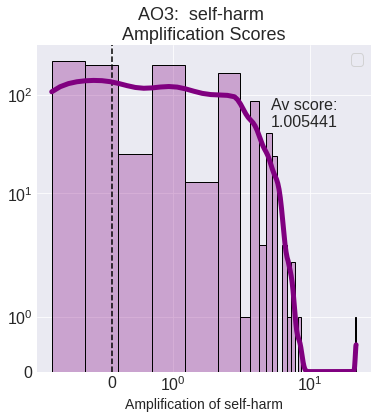

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for sexism: -0.49647300000000005


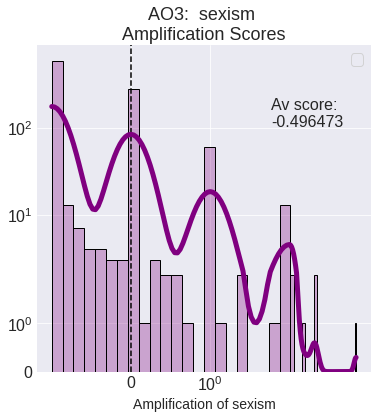

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-discrimination: -0.47219869696969696


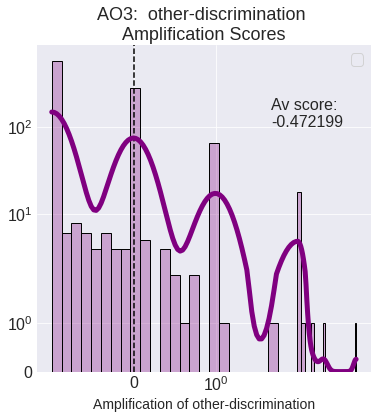

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-mental-health: 3.728780540001104


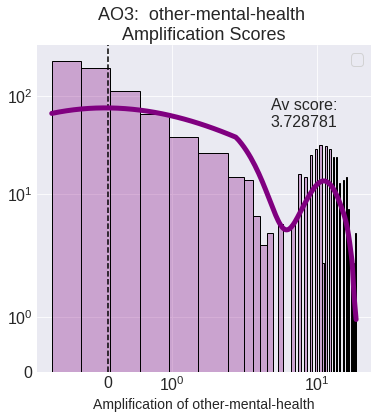

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abuse: 2.936967595226566


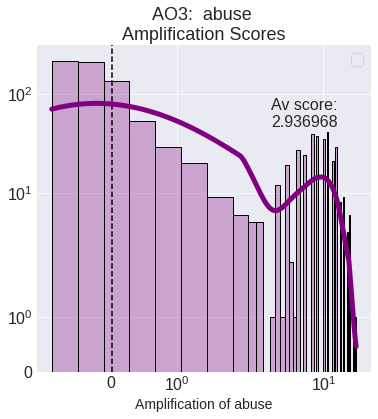

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abusive-language: 2.36821261329532


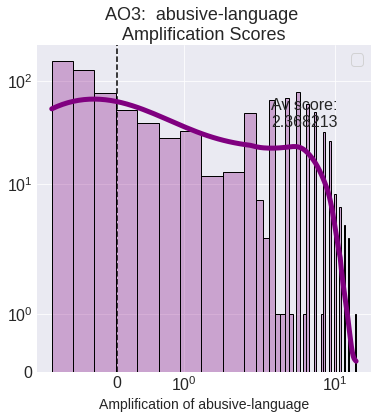

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for child-abuse: 1.4005797728185576


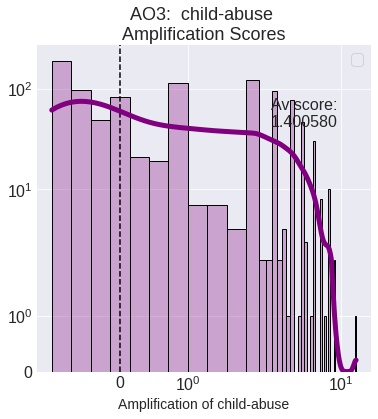

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for addiction: 1.7084707988823093


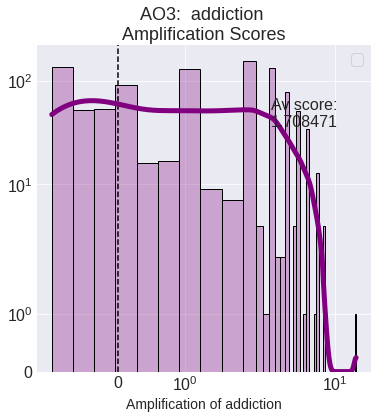

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-medical: 2.629097486004811


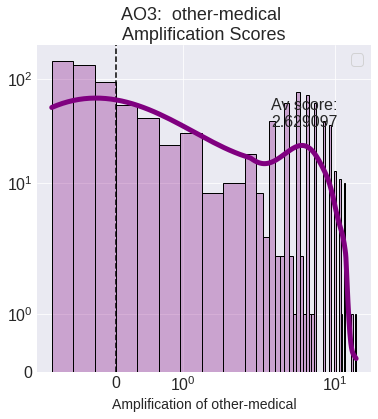

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for pornography: 2.984286689195577


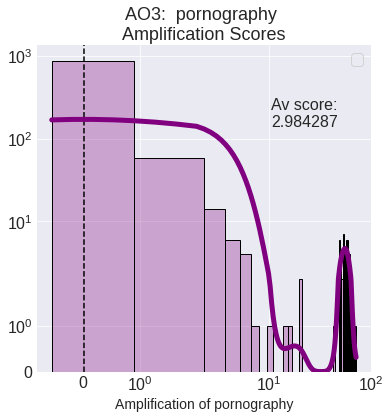

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for procedures: 0.35194629437229474


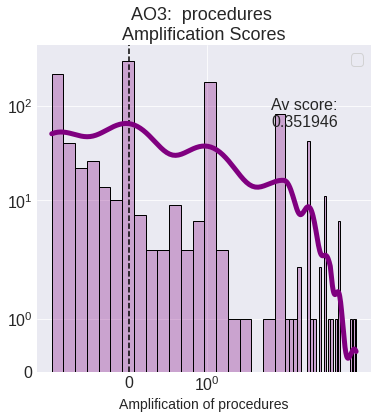

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abortion: -0.8027949999999999


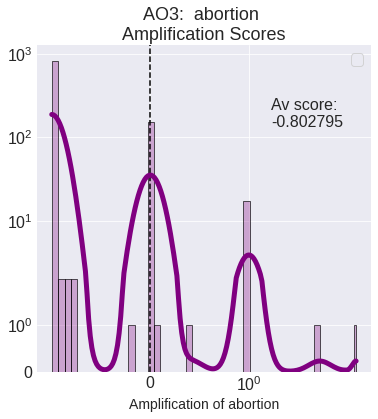

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for transphobia: -0.7482825000000001


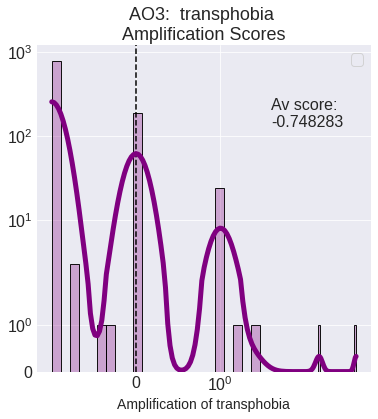

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for incest: 1.8381234338584744


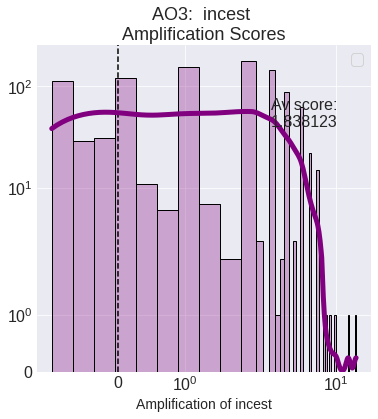

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for racism: -0.6046299999999999


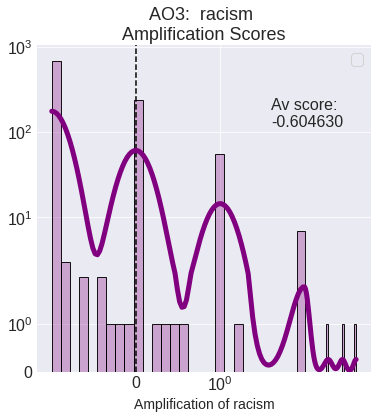

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for violence: 3.3984569071188924


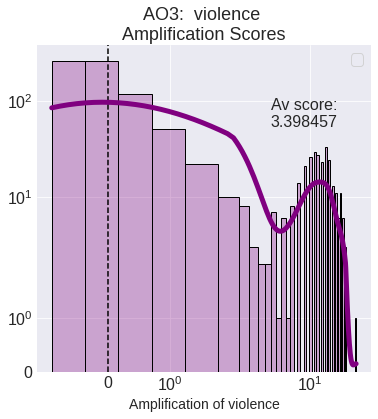

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for body-shaming: -0.973


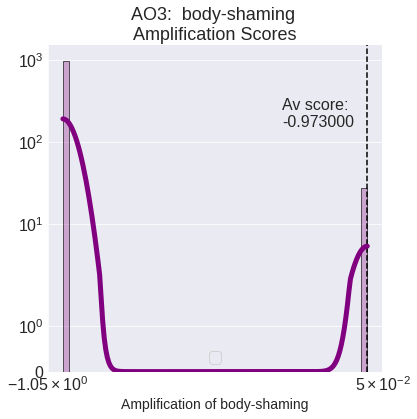

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-abuse: -0.49543299999999985


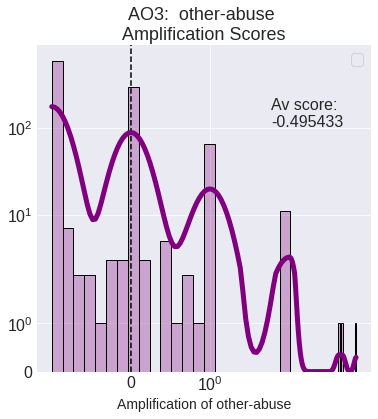

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for classism: -0.8899400000000001


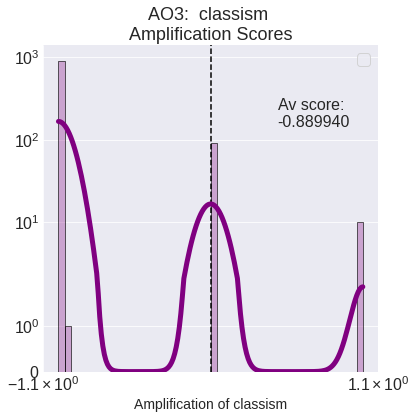

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-pregnancy: -0.4013283333333333


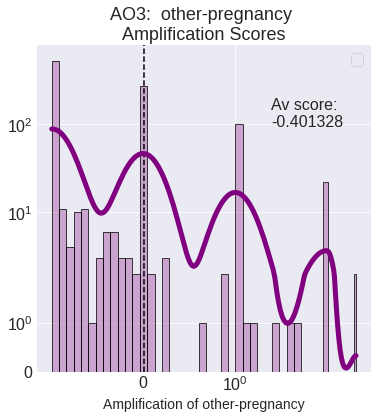

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for homophobia: 0.9602507550227547


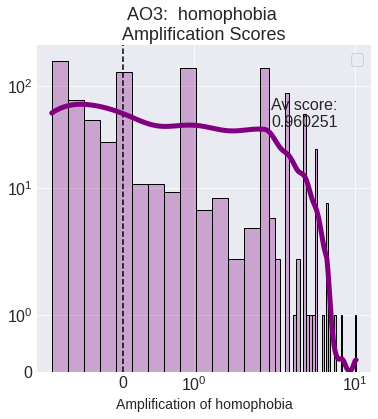

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for ableism: -0.875145


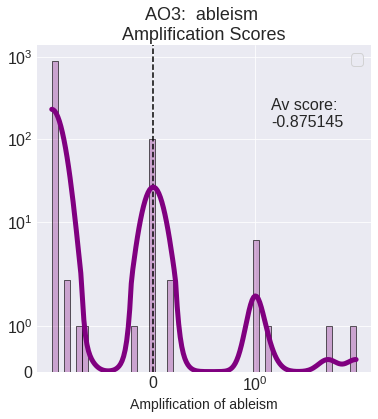

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for suicide: 2.153364687623972


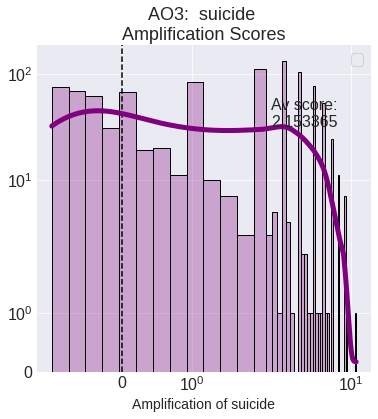

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for childbirth: 1.5095126070103262


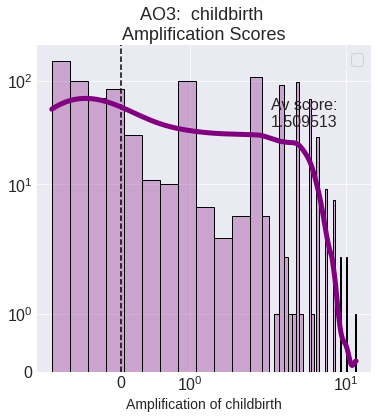

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for mental-illness: 1.6900999874692155


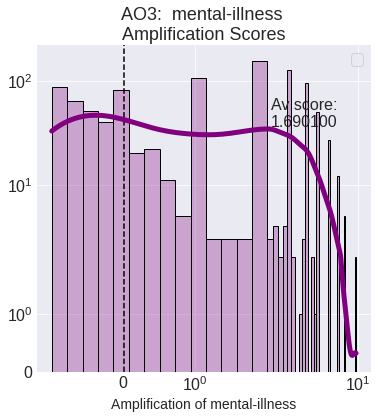

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for animal-abuse: -0.7507416666666665


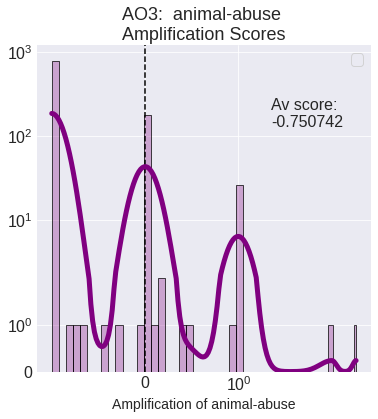

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for religious-discrimination: -0.873615


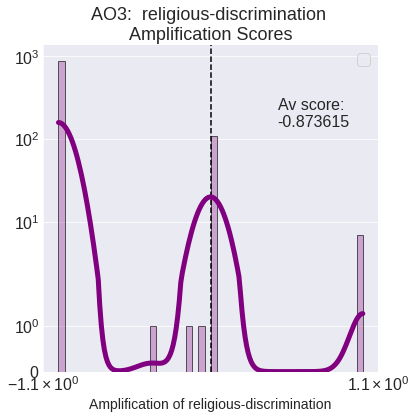

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for kidnapping: 0.8296875379402157


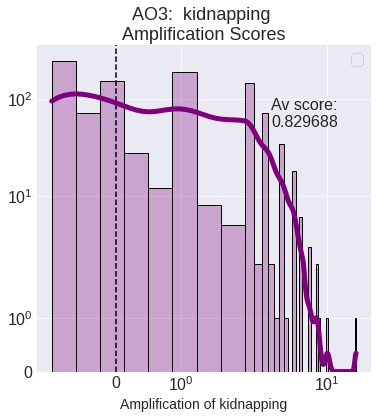

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for sexual-abuse: 3.317952291007201


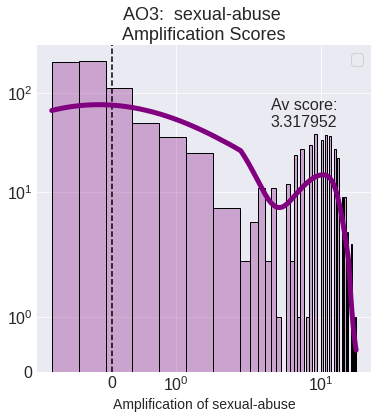

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for miscarriage: -0.7054900000000001


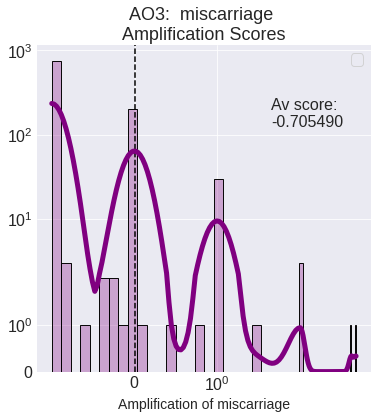

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for death: 4.411185586521764


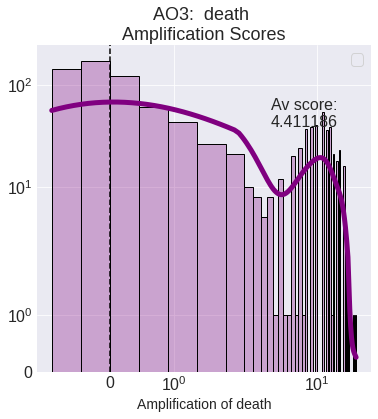

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for collective-violence: 0.5523043513708513


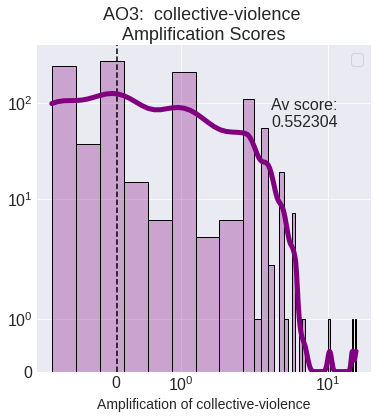

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-sexual: 2.8104965160126496


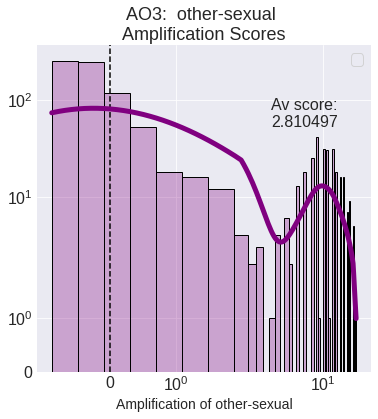

In [159]:
warning_amplification_plots(random_amplification_dfs)

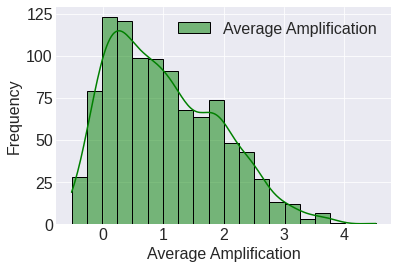

In [160]:
user_amplification_plots(random_amplification_dfs)

### ALS Algorithm

In [26]:
als_amplification_dfs = amplification_dfs(als_recs)

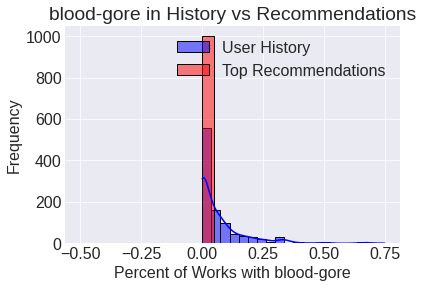

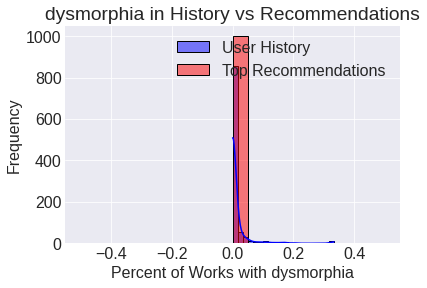

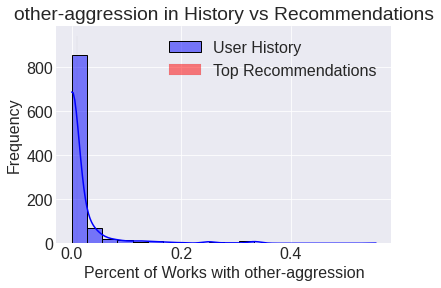

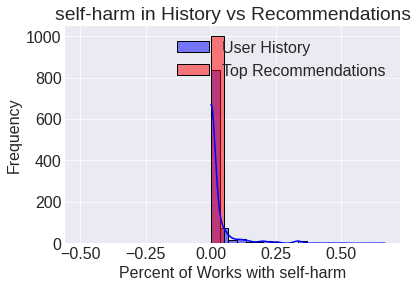

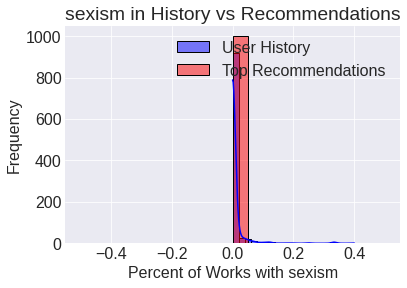

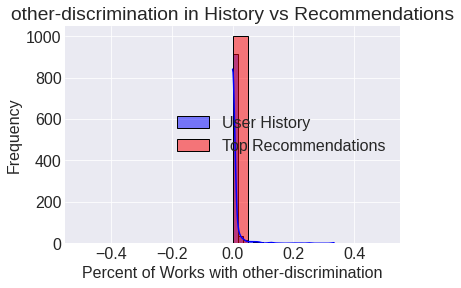

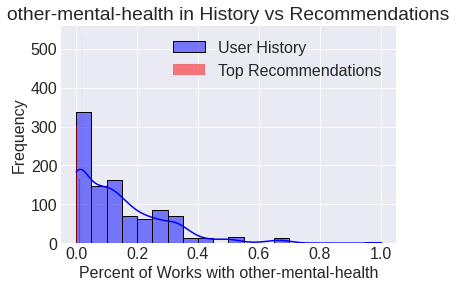

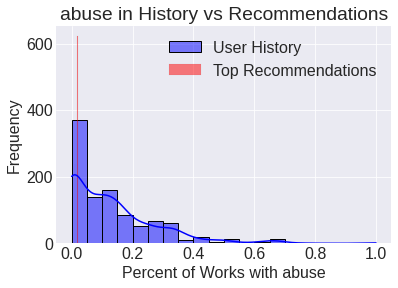

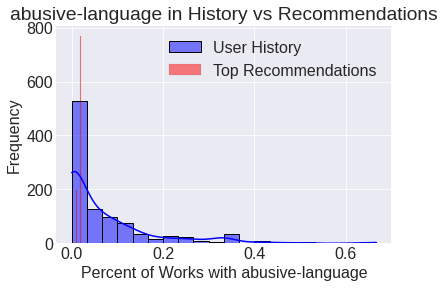

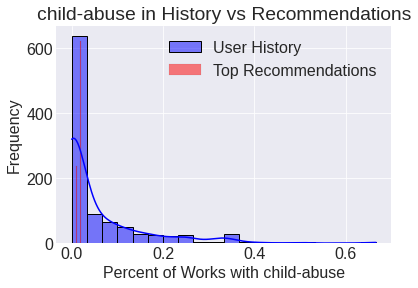

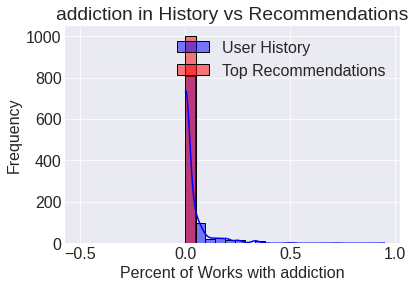

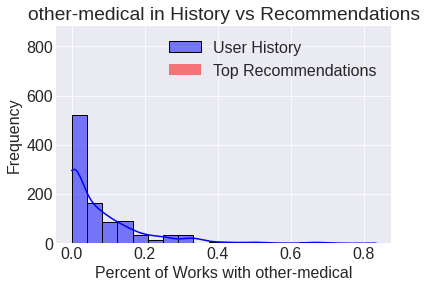

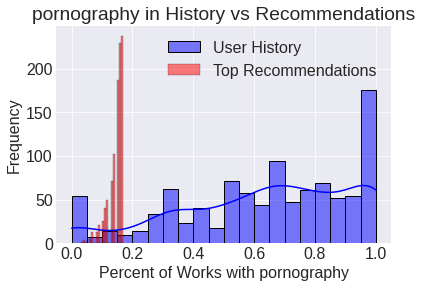

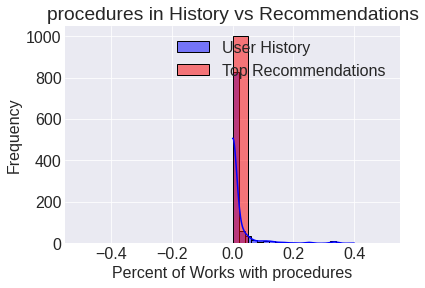

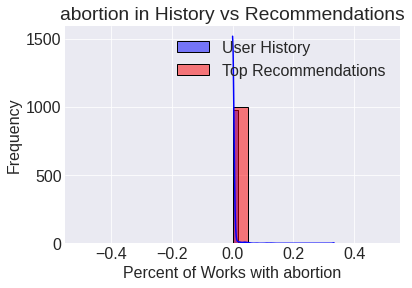

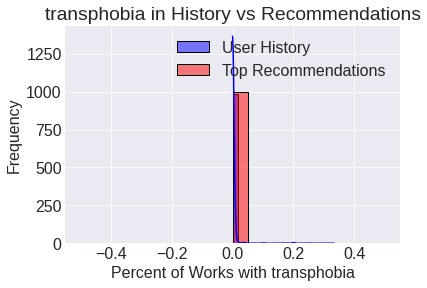

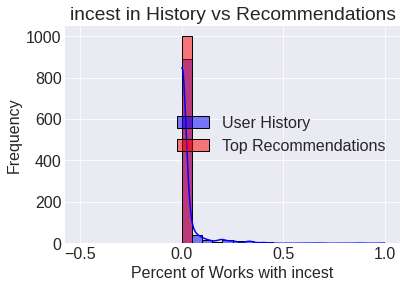

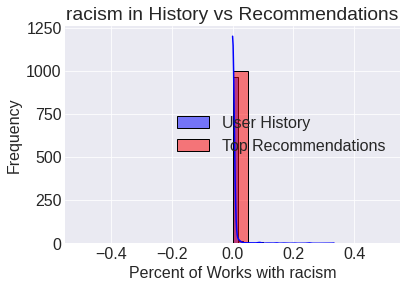

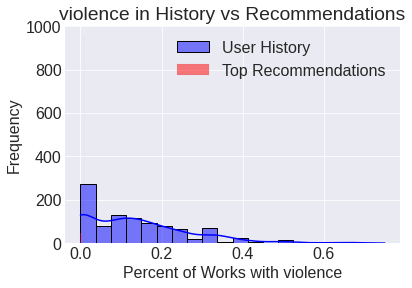

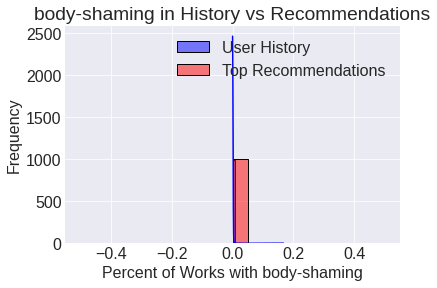

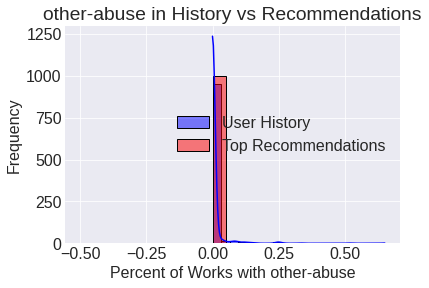

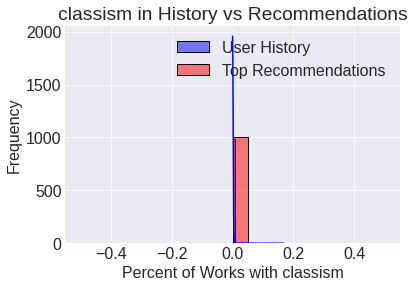

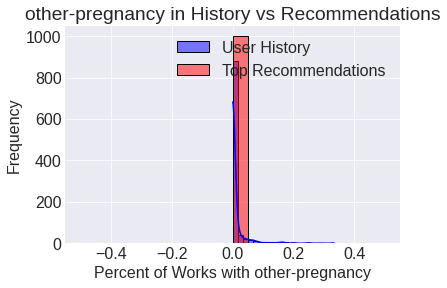

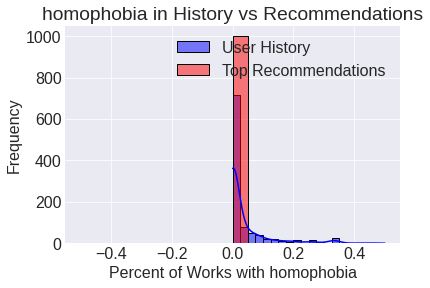

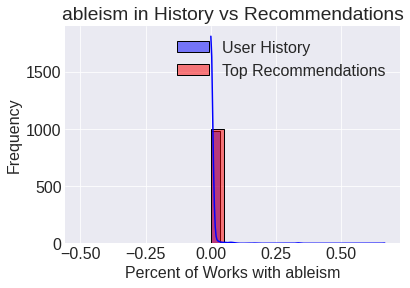

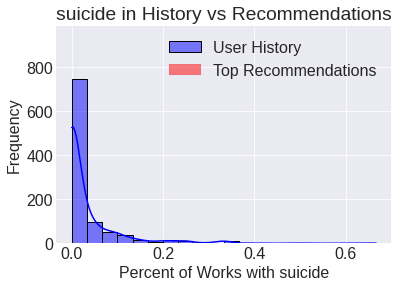

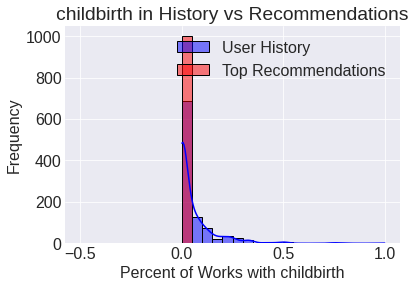

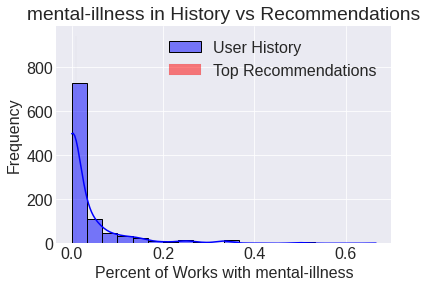

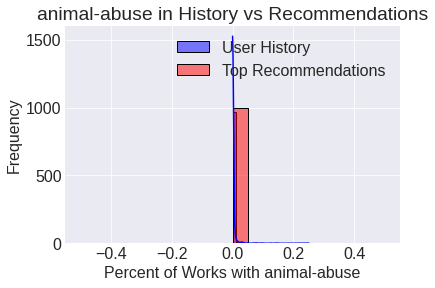

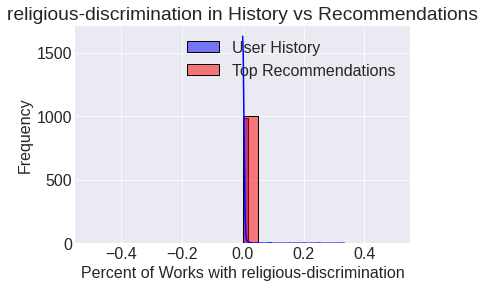

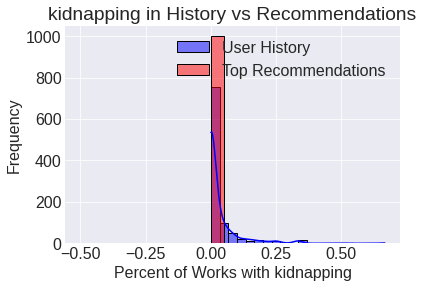

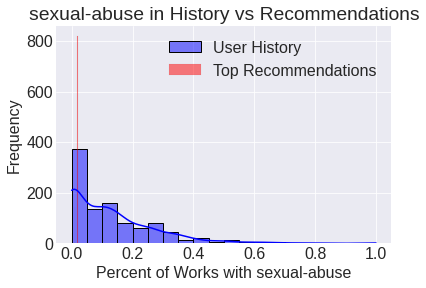

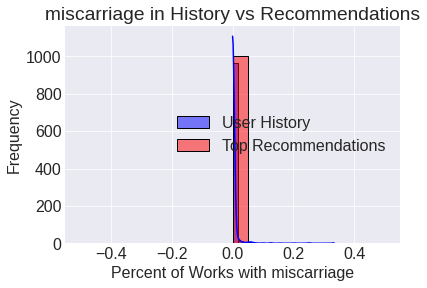

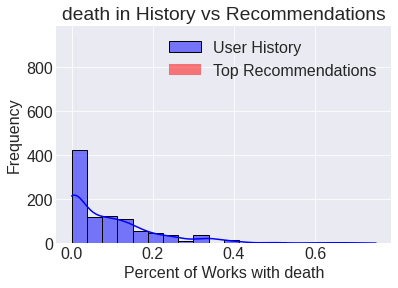

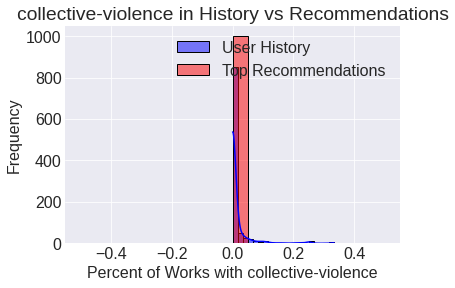

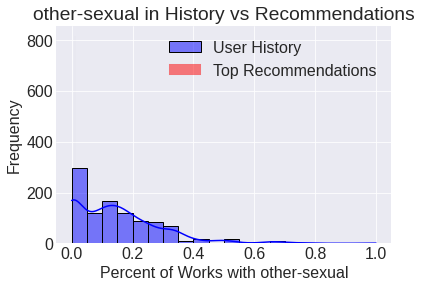

In [161]:
warning_distribution_plots(als_amplification_dfs)

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for blood-gore: -1.0


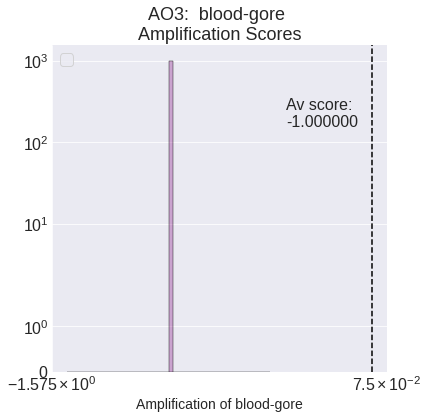

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for dysmorphia: -1.0


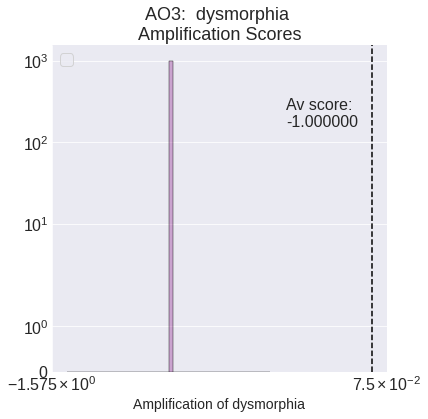

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-aggression: -0.19867382917521073


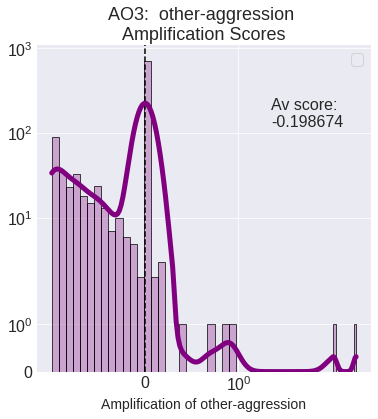

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for self-harm: -1.0


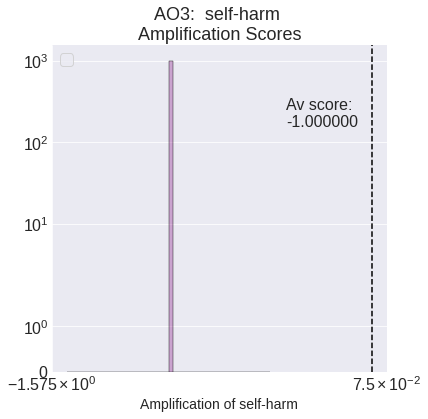

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for sexism: -1.0


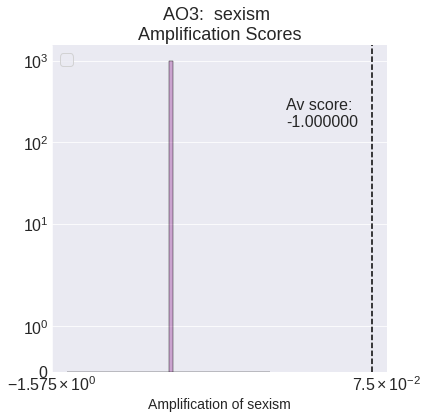

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-discrimination: -1.0


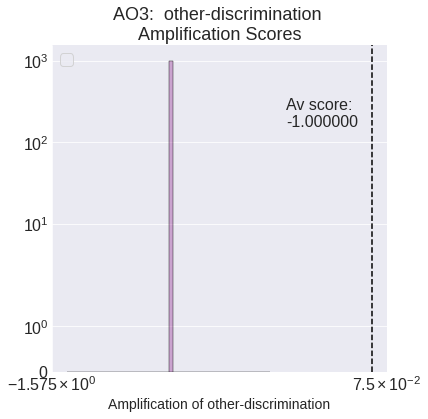

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-mental-health: -0.593567574378106


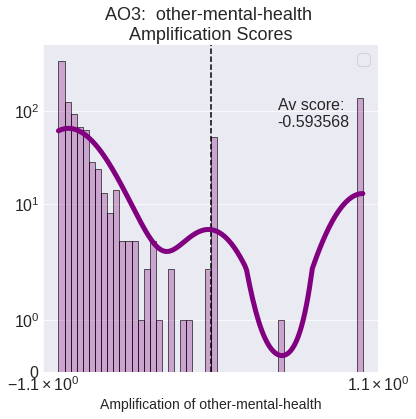

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abuse: -0.44336835645434836


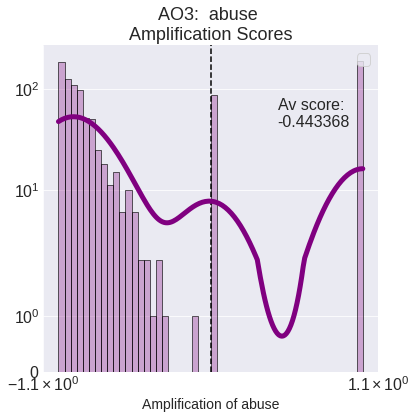

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abusive-language: -0.03396523118789346


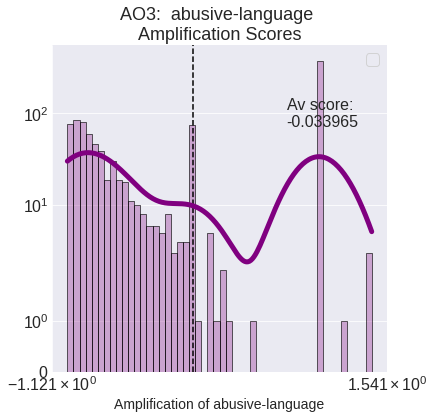

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for child-abuse: -0.04440127529063121


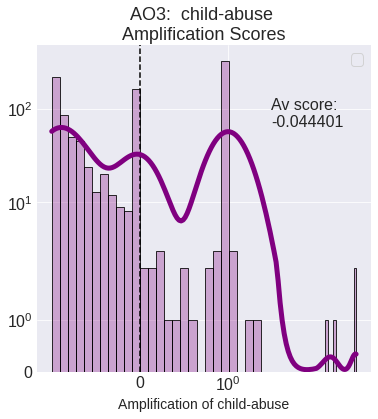

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for addiction: -1.0


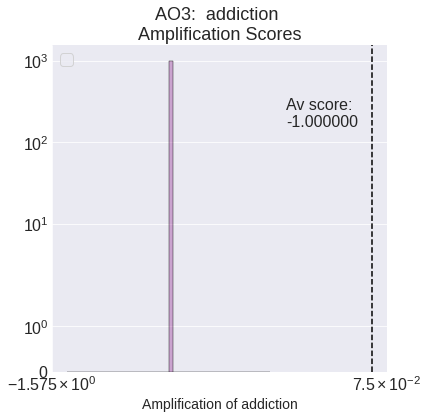

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-medical: -0.5488545275018828


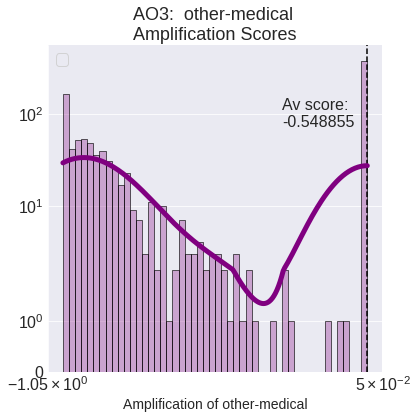

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for pornography: 0.002070788702350162


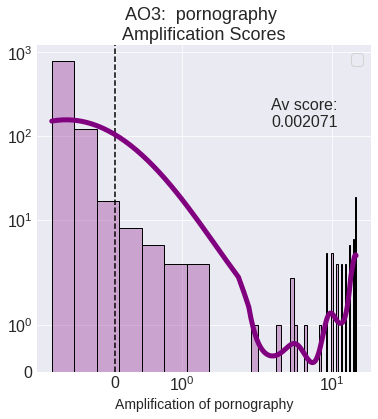

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for procedures: -1.0


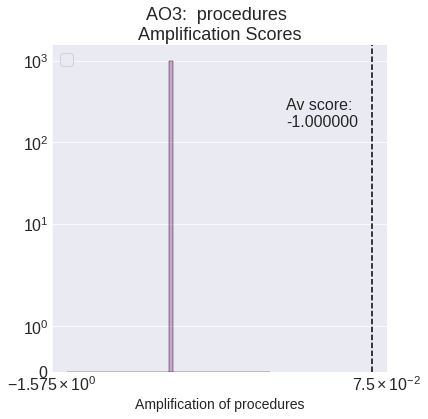

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for abortion: -1.0


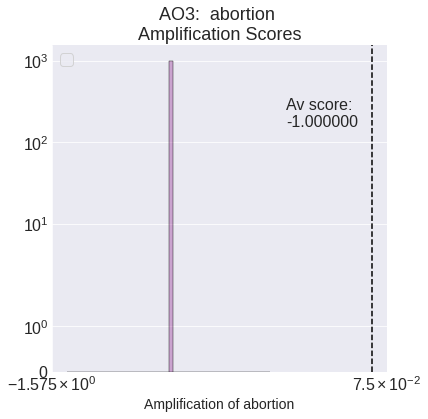

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for transphobia: -1.0


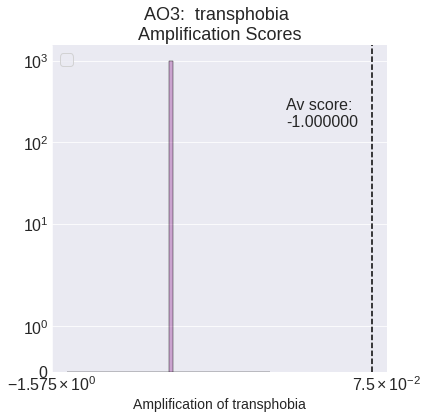

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for incest: -1.0


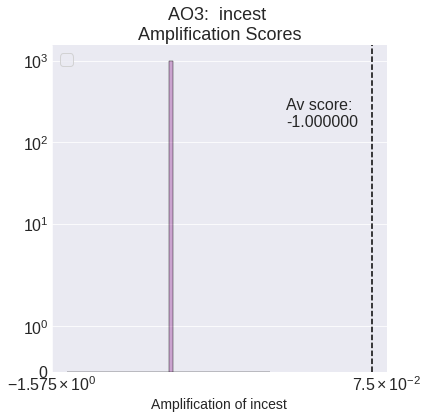

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for racism: -1.0


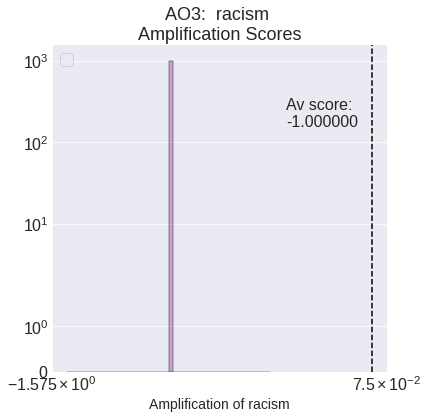

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for violence: -0.6934674592448026


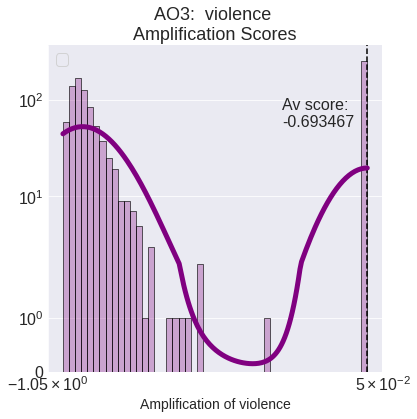

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for body-shaming: -1.0


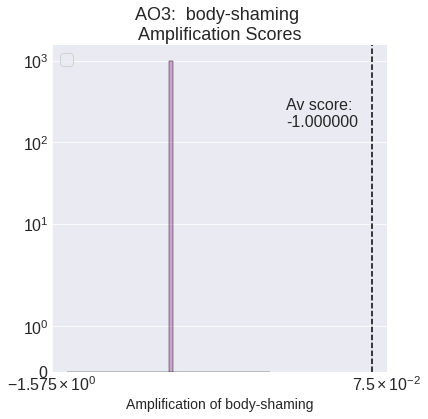

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-abuse: -1.0


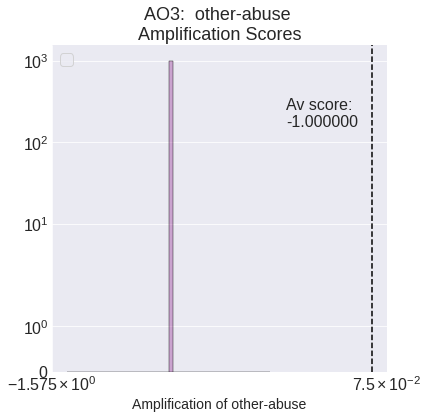

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for classism: -1.0


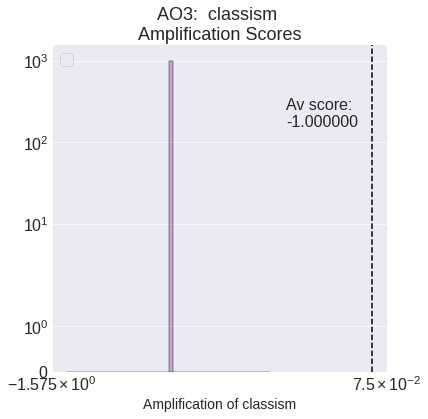

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-pregnancy: -1.0


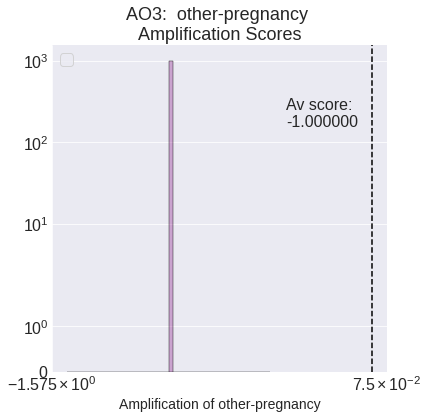

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for homophobia: -1.0


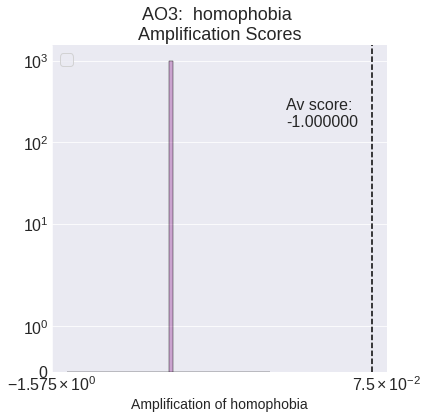

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for ableism: -1.0


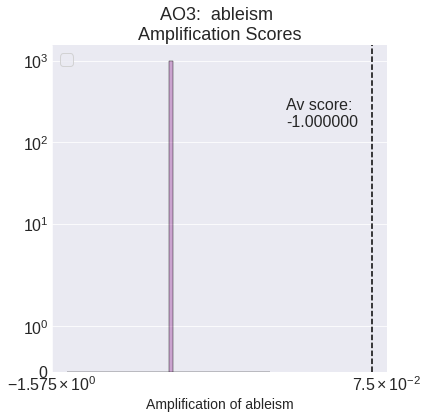

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for suicide: -0.31149197573563786


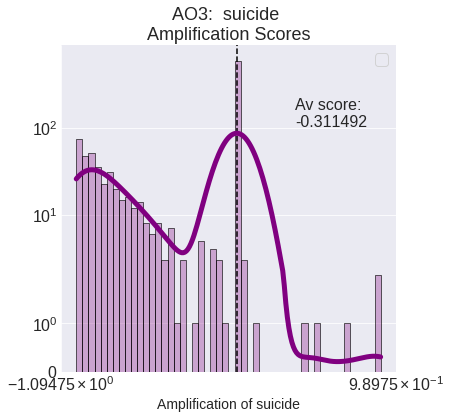

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for childbirth: -1.0


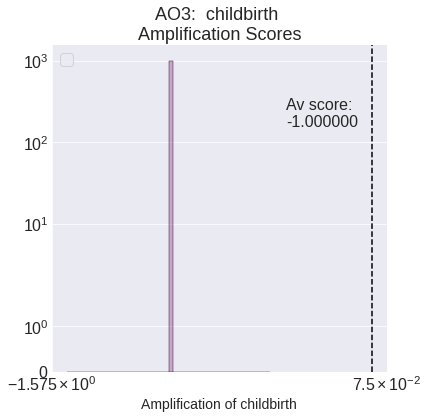

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for mental-illness: -0.3151645707945783


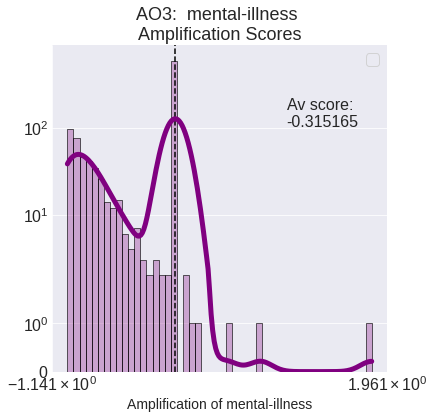

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for animal-abuse: -1.0


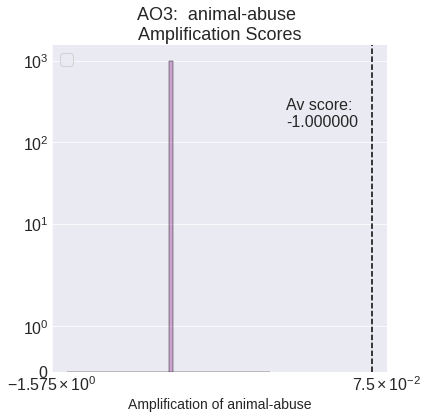

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for religious-discrimination: -1.0


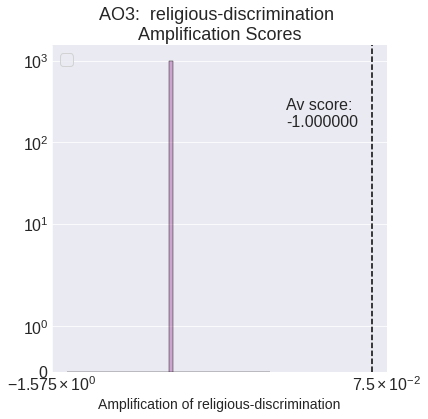

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for kidnapping: -1.0


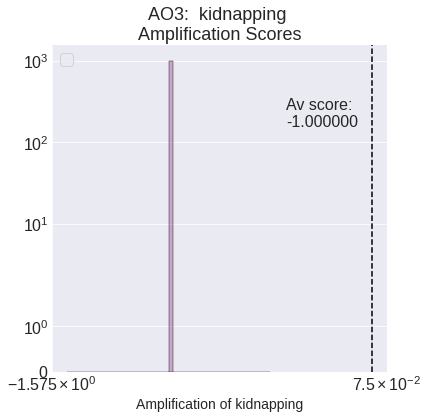

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for sexual-abuse: -0.29577295656455566


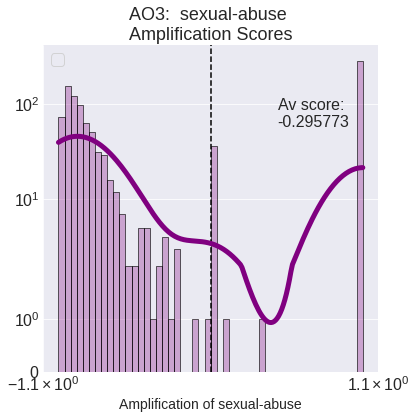

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for miscarriage: -1.0


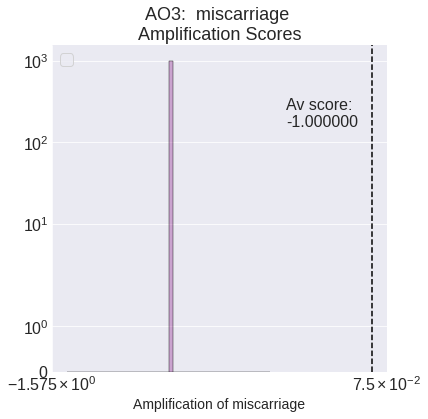

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for death: -0.5753588079412574


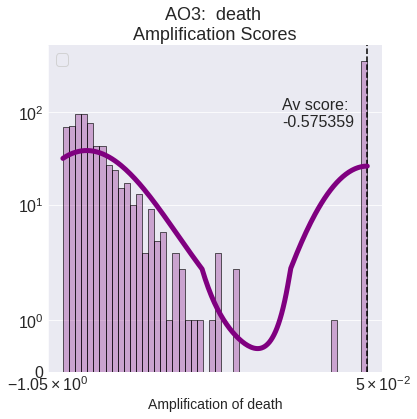

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for collective-violence: -1.0


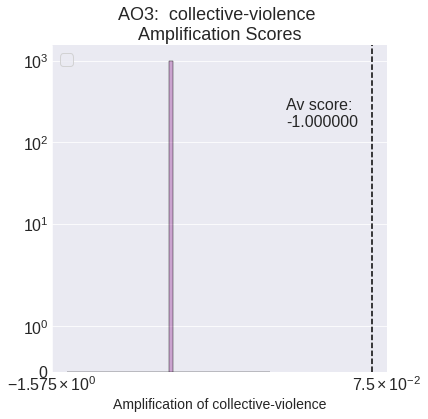

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 av amp for other-sexual: -0.7357852966177121


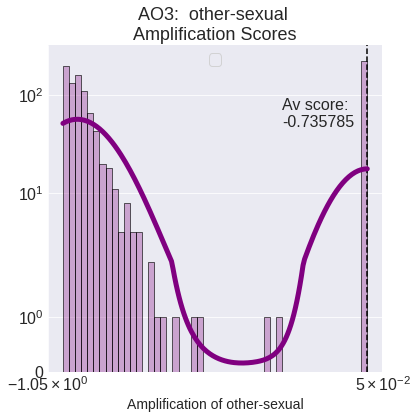

In [162]:
warning_amplification_plots(als_amplification_dfs)

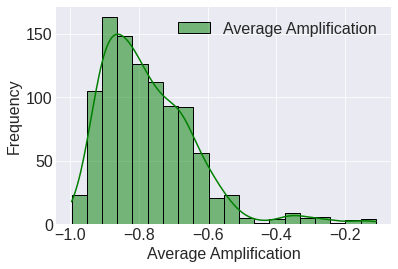

In [163]:
user_amplification_plots(als_amplification_dfs)

## Overall

Random av amp: 1.0186616614282569
ALS av amp: -0.7718833631162295
Top Pop av amp: 0.7520271431196294


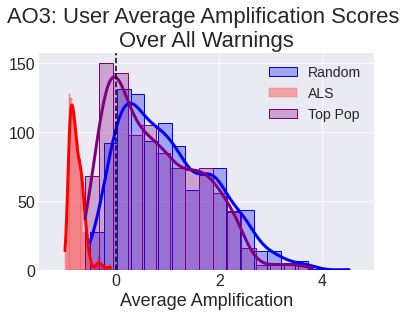

In [104]:
dms = [["Random", random_amplification_dfs, "blue"], ["ALS", als_amplification_dfs, "red"], ["Top Pop", top_pop_amplification_dfs, "purple"]]

overlay_user_amplifications(dms)

Random av amp for pornography: 2.984286689195577


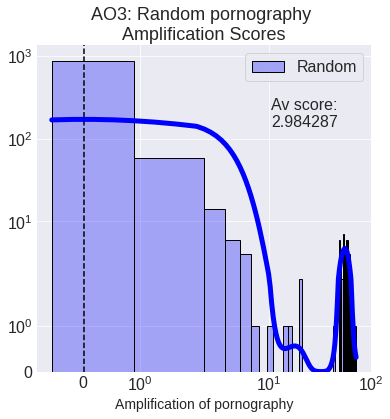

ALS av amp for pornography: 0.002070788702350162


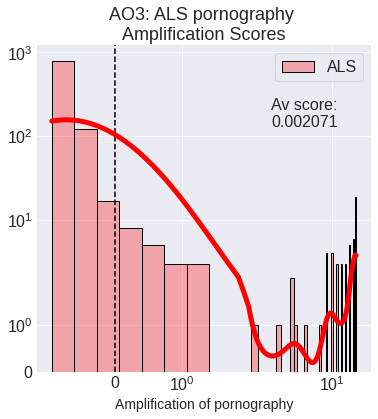

Top Pop av amp for pornography: 3.0457541992582993


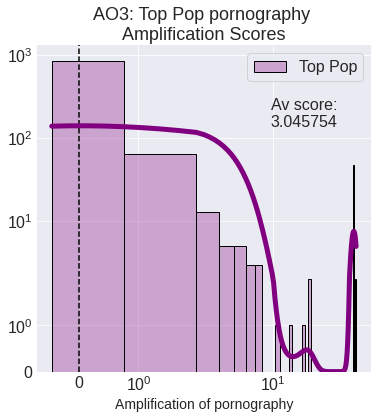

In [164]:
single_warning_amplification("pornography", random_amplification_dfs, "Random", "blue")
single_warning_amplification("pornography", als_amplification_dfs, "ALS", "red")
single_warning_amplification("pornography", top_pop_amplification_dfs, "Top Pop", "purple")

Random av amp for blood-gore: 2.452120488397762


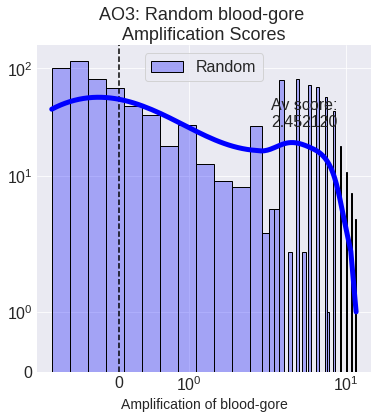

ALS av amp for blood-gore: -1.0


/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


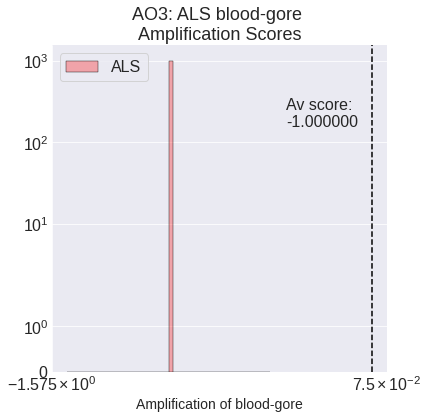

Top Pop av amp for blood-gore: 0.1189764929500245


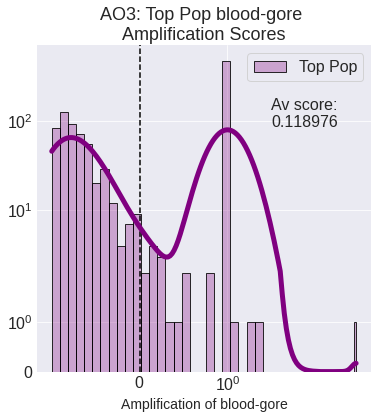

In [165]:
single_warning_amplification("blood-gore", random_amplification_dfs, "Random", "blue")
single_warning_amplification("blood-gore", als_amplification_dfs, "ALS", "red")
single_warning_amplification("blood-gore", top_pop_amplification_dfs, "Top Pop", "purple")

Random av amp for death: 4.411185586521764


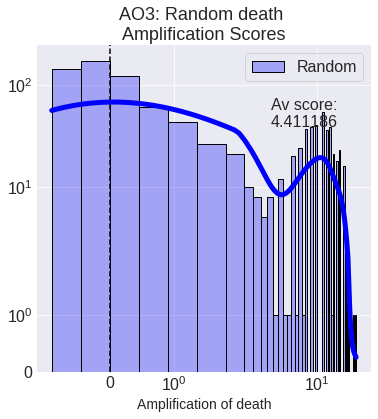

ALS av amp for death: -0.5753588079412574


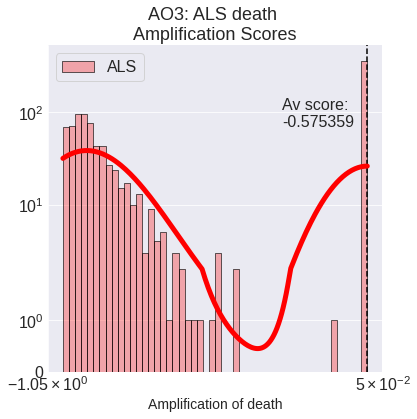

Top Pop av amp for death: 4.0243023235575555


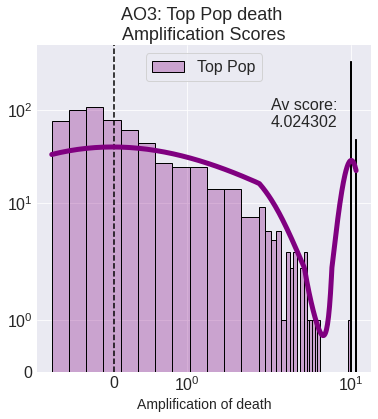

In [166]:
single_warning_amplification("death", random_amplification_dfs, "Random", "blue")
single_warning_amplification("death", als_amplification_dfs, "ALS", "red")
single_warning_amplification("death", top_pop_amplification_dfs, "Top Pop", "purple")

ALS av amp for pornography: 0.002070788702350162
Random av amp for pornography: 2.984286689195577
Top Pop av amp for pornography: 3.0457541992582993


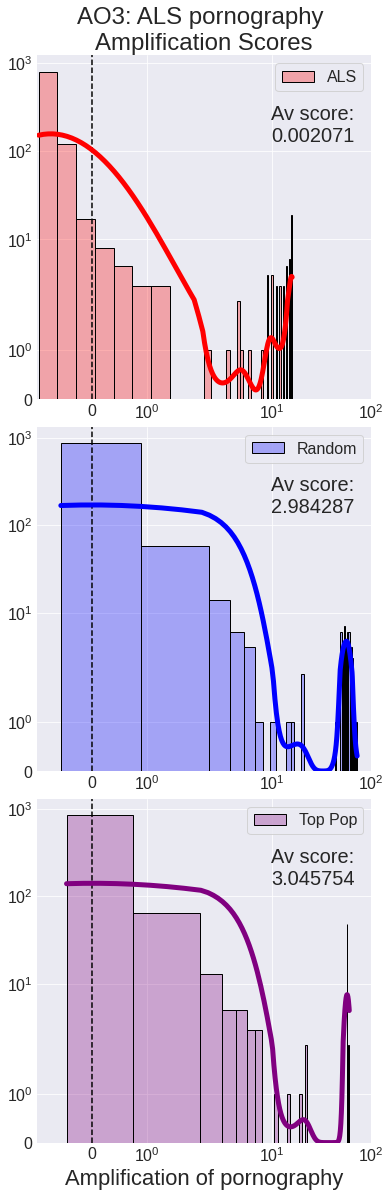

In [154]:
fig, axes = plt.subplots(3, 1, figsize=(6, 20))
plt.subplots_adjust(hspace=0.08)


warning, warning_data_maps, name, color = "pornography", als_amplification_dfs, "ALS", "red"
data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])
av_amp = data["amplification_scores"].mean()
print(f"{name} av amp for {warning}: {av_amp}")
axes[0].axvline(x = 0, ymin = 0, ymax = 1, color="black", linestyle="dashed")
axes[0].set_yscale('symlog')
axes[0].set_xscale('symlog')
axes[0].set_xlim(-1, 100)
axes[0].text(0.7, 0.75, f"Av score: \n{av_amp:2f}", transform = axes[0].transAxes, fontsize=20)
sns.histplot(data=data["amplification_scores"], kde=True, bins=50, line_kws={'lw':5}, color=color, label=f'{name}', alpha=0.3, ax=axes[0])
axes[0].set_title(f'AO3: {name} {warning} \nAmplification Scores', fontsize=24)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].legend(loc='best', frameon=True)

warning, warning_data_maps, name, color = "pornography", random_amplification_dfs, "Random", "blue"
data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])
av_amp = data["amplification_scores"].mean()
print(f"{name} av amp for {warning}: {av_amp}")
axes[1].axvline(x = 0, ymin = 0, ymax = 1, color="black", linestyle="dashed")
axes[1].set_yscale('symlog')
axes[1].set_xscale('symlog')
axes[1].set_xlim(-1, 100)
axes[1].text(0.7, 0.75, f"Av score: \n{av_amp:2f}", transform = axes[1].transAxes, fontsize=20)
sns.histplot(data=data["amplification_scores"], kde=True, bins=50, line_kws={'lw':5}, color=color, label=f'{name}', alpha=0.3, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend(loc='best', frameon=True)

warning, warning_data_maps, name, color = "pornography", top_pop_amplification_dfs, "Top Pop", "purple"
data = pd.DataFrame(warning_data_maps[warning_data_maps["warning"] == warning]["data"].iloc[0])
av_amp = data["amplification_scores"].mean()
print(f"{name} av amp for {warning}: {av_amp}")
axes[2].axvline(x = 0, ymin = 0, ymax = 1, color="black", linestyle="dashed")
axes[2].set_yscale('symlog')
axes[2].set_xscale('symlog')
axes[2].set_xlim(-1, 100)
axes[2].text(0.7, 0.75, f"Av score: \n{av_amp:2f}", transform = axes[2].transAxes, fontsize=20)
sns.histplot(data=data["amplification_scores"], kde=True, bins=50, line_kws={'lw':5}, color=color, label=f'{name}', alpha=0.3, ax=axes[2])
axes[2].set_xlabel(f'Amplification of {warning}', fontsize=22)
axes[2].set_ylabel('')
axes[2].legend(loc='best', frameon=True)

plt.show()